In [1]:
import cv2
import os
from tqdm.notebook import tqdm
import numpy as np
np.random.seed(43)

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
torch.manual_seed(43)
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, RandomSampler
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip "/content/drive/My Drive/IIIT HYDERABAD/SEMESTER 6/CV/Assignment 5/train.zip" -d "/content/temp_train/"
!unzip "/content/drive/My Drive/IIIT HYDERABAD/SEMESTER 6/CV/Assignment 5/test.zip" -d "/content/temp_test/"

!mv "/content/temp_train/content/drive/MyDrive/CV_a5/train_images/" "/content/"
!mv "/content/temp_test/content/drive/MyDrive/CV_a5/test_images/" "/content/"

!cp "/content/drive/My Drive/IIIT HYDERABAD/SEMESTER 6/CV/Assignment 5/train.csv" "/content/"
!cp "/content/drive/My Drive/IIIT HYDERABAD/SEMESTER 6/CV/Assignment 5/test.csv" "/content/"
!cp "/content/drive/My Drive/IIIT HYDERABAD/SEMESTER 6/CV/Assignment 5/dataset_info.txt" "/content/"
!rm -r "/content/temp_train"
!rm -r "/content/temp_test"

Streaming output truncated to the last 5000 lines.
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/f44c29ece5.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/45dba3fe97.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/c756b82015.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/0e2bdc7ba8.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/b5cbc0056c.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/10982b2133.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/617b7641b3.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/6601b6bd82.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/579bf0df0c.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/b6768f2f16.jpg  
  inflating: /content/temp_train/conten

In [4]:
print(len(os.listdir('/content/test_images')))
print(len(os.listdir('/content/train_images')))

484
9324


In [5]:
assign_path = "/content/"

train_path = assign_path + "train_images/"
train_csv = assign_path + "train.csv"
test_path = assign_path + "test_images/"
test_csv = assign_path + "test.csv"
class_info = assign_path + "dataset_info.txt"

In [6]:
with open(class_info, 'r') as f:
    data = f.read()
    data = data.split('\n')[1:]
    classes = []
    for i in data:
        classes.append(i.split('.')[1].strip())

class2index = {c: i for i, c in enumerate(classes)}
index2class = {class2index[c]: c for c in class2index}

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, folder, class2index, transform=None):
        self.df = pd.read_csv(csv_path)
        self.folder = folder
        self.transform = transform
        self.class2index = class2index
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        fname = self.df['ImageId'][index]
        label = self.class2index[self.df["ClassName"][index]]
        image = Image.open(os.path.join(self.folder, fname))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64))
])

dataset = Dataset(train_csv, train_path, class2index, transform)

In [ ]:
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)

class DeviceLoader():
    def __init__(self, loader, device):
        self.loader = loader
        self.device = device

    def __iter__(self):
        for batch in self.loader:
            yield to_device(batch, self.device)

In [8]:
def train(model, train_loader, val_loader, epochs, lr, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }

    min_val_loss = np.inf
    max_val_acc = 0
    for epoch in tqdm(range(epochs)):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            imgs, labs = batch
            out = model.forward(imgs)
            loss = nn.CrossEntropyLoss()(out, labs)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        val_accs = []
        for batch in tqdm(val_loader):
            imgs, labs = batch
            out = model.forward(imgs)
            loss = nn.CrossEntropyLoss()(out, labs)
            val_losses.append(loss)
            acc = accuracy(out, labs)
            val_accs.append(acc)
        
        history['train_loss'].append(torch.stack(train_losses).mean().item())
        history['val_loss'].append(torch.stack(val_losses).mean().item())
        history['val_acc'].append(torch.stack(val_accs).mean().item())

        if history['val_loss'][epoch] < min_val_loss:
            min_val_loss = history['val_loss'][epoch]
            torch.save(model, './best_loss_model')

        if history['val_acc'][epoch] < max_val_acc:
            max_val_acc = history['val_acc'][epoch]
            torch.save(model, './best_acc_model')
        
        print('Epoch: ' + str(epoch+1) + ', Train loss: ' + str(history['train_loss'][epoch])
                            + ', Validation loss: ' + str(history['val_loss'][epoch])
                            + ', Validation accuracy: ' + str(history['val_acc'][epoch]))
        
    return history

def accuracy(outputs, labels):
    softmax = nn.Softmax(dim=1)
    _, preds = torch.max(softmax(outputs), dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
def plot_graphs(history):
    fig = plt.figure(figsize=(24, 8))

    # Train Loss and Validation loss
    axs = fig.add_subplot(121)
    no_ep = len(history['val_loss'])
    axs.plot(np.arange(no_ep)+1, history['train_loss'], label='Train Loss')
    axs.plot(np.arange(no_ep)+1, history['val_loss'], label='Val Loss')
    axs.set_title('Losses vs Epoch', fontsize=20)
    axs.xaxis.label.set_size(40)
    axs.set_xlabel('Epoch', fontsize=15)
    axs.set_ylabel('Loss', fontsize=15)
    axs.legend(fontsize=15)

    # Validation accuracy
    axs = fig.add_subplot(122)
    no_ep = len(history['val_acc'])
    axs.plot(np.arange(no_ep)+1, history['val_acc'])
    axs.set_title('Validation accuracy vs Epoch', fontsize=20)
    axs.set_xlabel('Epoch', fontsize=15)
    axs.set_ylabel('Validation accuracy', fontsize=15)

In [ ]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True)

In [ ]:
train_dl = DeviceLoader(train_dl, device)
val_dl = DeviceLoader(val_dl, device)

# Baseline Model

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62)
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.8009023666381836, Validation loss: 3.5452396869659424, Validation accuracy: 0.17476850748062134



Epoch: 2, Train loss: 3.293173313140869, Validation loss: 3.2278521060943604, Validation accuracy: 0.20358796417713165



Epoch: 3, Train loss: 3.0353925228118896, Validation loss: 3.179802417755127, Validation accuracy: 0.22337962687015533



Epoch: 4, Train loss: 2.885687828063965, Validation loss: 3.02030086517334, Validation accuracy: 0.23935183882713318



Epoch: 5, Train loss: 2.690101385116577, Validation loss: 3.0244717597961426, Validation accuracy: 0.23414351046085358



Epoch: 6, Train loss: 2.4279983043670654, Validation loss: 2.962477445602417, Validation accuracy: 0.25833332538604736



Epoch: 7, Train loss: 2.0780863761901855, Validation loss: 3.1826560497283936, Validation accuracy: 0.24085648357868195



Epoch: 8, Train loss: 1.6704670190811157, Validation loss: 3.2556653022766113, Validation accuracy: 0.24363425374031067



Epoch: 9, Train loss: 1.2552039623260498, Validation loss: 3.736119270324707, Validation accuracy: 0.2359953671693802



Epoch: 10, Train loss: 0.8708454370498657, Validation loss: 4.165708065032959, Validation accuracy: 0.23564815521240234



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.8009023666381836	Val loss:  3.5452396869659424	Val acc: 0.17476850748062134
Epoch: 2	Train loss: 3.293173313140869	Val loss:  3.2278521060943604	Val acc: 0.20358796417713165
Epoch: 3	Train loss: 3.0353925228118896	Val loss:  3.179802417755127	Val acc: 0.22337962687015533
Epoch: 4	Train loss: 2.885687828063965	Val loss:  3.02030086517334	Val acc: 0.23935183882713318
Epoch: 5	Train loss: 2.690101385116577	Val loss:  3.0244717597961426	Val acc: 0.23414351046085358
Epoch: 6	Train loss: 2.4279983043670654	Val loss:  2.962477445602417	Val acc: 0.25833332538604736
Epoch: 7	Train loss: 2.0780863761901855	Val loss:  3.1826560497283936	Val acc: 0.24085648357868195
Epoch: 8	Train loss: 1.6704670190811157	Val loss:  3.2556653022766113	Val acc: 0.24363425374031067
Epoch: 9	Train loss: 1.2552039623260498	Val loss:  3.736119270324707	Val acc: 0.2359953671693802
Epoch: 10	Train loss: 0.8708454370498657	Val loss:  4.165708065032959	Val acc: 0.23564815521240234


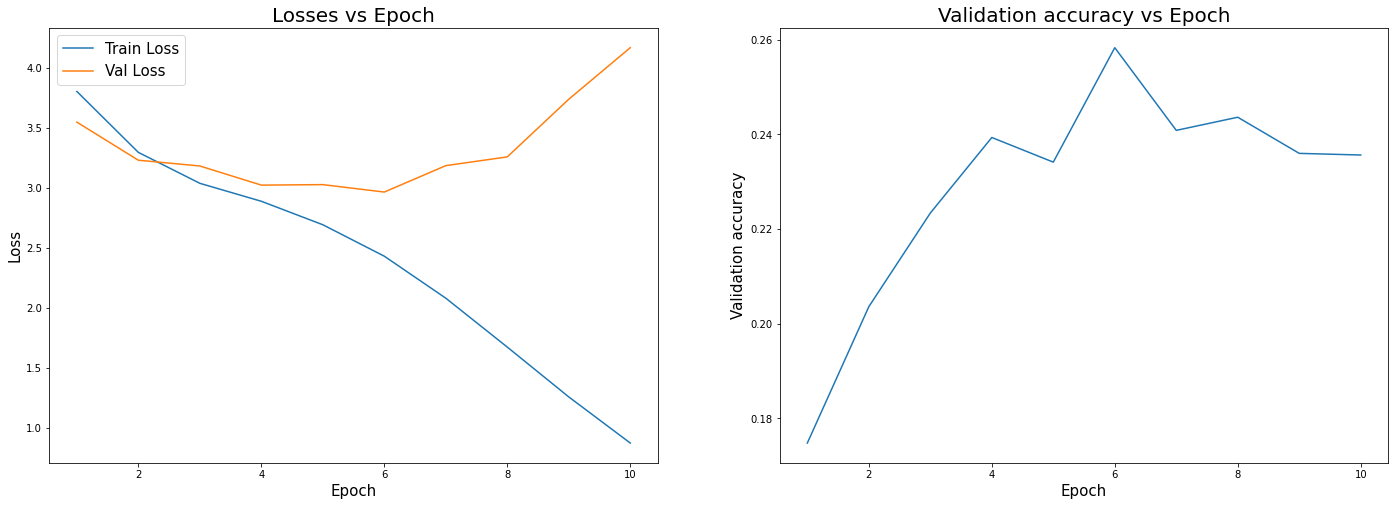

In [ ]:
plot_graphs(history)

# Using batch norm

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.BatchNorm1d(256*16*16),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 62)
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=65536, out_features=512, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.2514564990997314, Validation loss: 3.012204170227051, Validation accuracy: 0.25



Epoch: 2, Train loss: 2.4273276329040527, Validation loss: 2.842170238494873, Validation accuracy: 0.2864583432674408



Epoch: 3, Train loss: 1.484918236732483, Validation loss: 2.940523862838745, Validation accuracy: 0.3011574149131775



Epoch: 4, Train loss: 0.4707016348838806, Validation loss: 2.9925129413604736, Validation accuracy: 0.30775463581085205



Epoch: 5, Train loss: 0.1513270139694214, Validation loss: 3.1031506061553955, Validation accuracy: 0.3010416626930237



Epoch: 6, Train loss: 0.07494168728590012, Validation loss: 3.1943564414978027, Validation accuracy: 0.3003472089767456



Epoch: 7, Train loss: 0.046070754528045654, Validation loss: 3.275946617126465, Validation accuracy: 0.3201388716697693



Epoch: 8, Train loss: 0.048966195434331894, Validation loss: 3.3419060707092285, Validation accuracy: 0.30520832538604736



Epoch: 9, Train loss: 0.04391368478536606, Validation loss: 3.377659797668457, Validation accuracy: 0.3064814805984497



Epoch: 10, Train loss: 0.02558758109807968, Validation loss: 3.4630534648895264, Validation accuracy: 0.3115740716457367



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '   \t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.2514564990997314   	Val loss:  3.012204170227051	Val acc: 0.25
Epoch: 2	Train loss: 2.4273276329040527   	Val loss:  2.842170238494873	Val acc: 0.2864583432674408
Epoch: 3	Train loss: 1.484918236732483   	Val loss:  2.940523862838745	Val acc: 0.3011574149131775
Epoch: 4	Train loss: 0.4707016348838806   	Val loss:  2.9925129413604736	Val acc: 0.30775463581085205
Epoch: 5	Train loss: 0.1513270139694214   	Val loss:  3.1031506061553955	Val acc: 0.3010416626930237
Epoch: 6	Train loss: 0.07494168728590012   	Val loss:  3.1943564414978027	Val acc: 0.3003472089767456
Epoch: 7	Train loss: 0.046070754528045654   	Val loss:  3.275946617126465	Val acc: 0.3201388716697693
Epoch: 8	Train loss: 0.048966195434331894   	Val loss:  3.3419060707092285	Val acc: 0.30520832538604736
Epoch: 9	Train loss: 0.04391368478536606   	Val loss:  3.377659797668457	Val acc: 0.3064814805984497
Epoch: 10	Train loss: 0.02558758109807968   	Val loss:  3.4630534648895264	Val acc: 0.3115740716457367


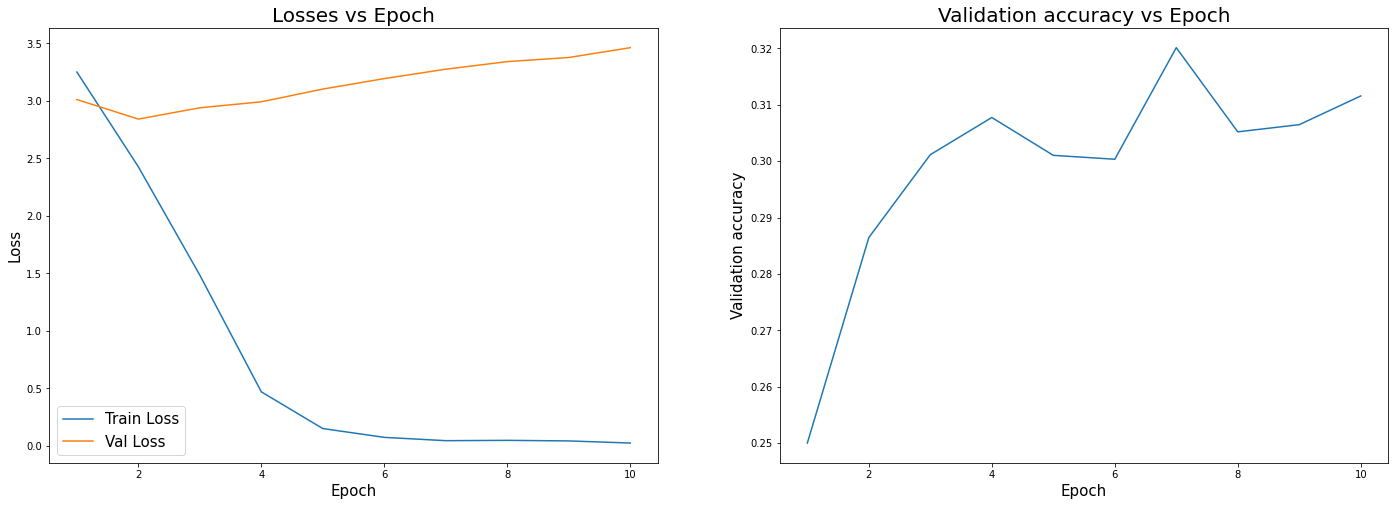

In [ ]:
plot_graphs(history)

# Adding new layers

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 1024 x 4 x 4
            nn.Flatten(),
            nn.Linear(1024*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 62)
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=16384, out_features=1024, bias=True)
    (14): ReLU()
    (15): Linear(in_features=1024, out_features=512, bias=True)
    (16): ReLU()
    (17): Linear(in_features=512, out_featur

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.8450374603271484, Validation loss: 3.8195338249206543, Validation accuracy: 0.09826388210058212



Epoch: 2, Train loss: 3.712794542312622, Validation loss: 3.670804500579834, Validation accuracy: 0.135532408952713



Epoch: 3, Train loss: 3.4650380611419678, Validation loss: 3.4345204830169678, Validation accuracy: 0.17291666567325592



Epoch: 4, Train loss: 3.2995402812957764, Validation loss: 3.3094592094421387, Validation accuracy: 0.19131943583488464



Epoch: 5, Train loss: 3.1843953132629395, Validation loss: 3.223191261291504, Validation accuracy: 0.21458333730697632



Epoch: 6, Train loss: 3.080838680267334, Validation loss: 3.2902259826660156, Validation accuracy: 0.19664351642131805



Epoch: 7, Train loss: 2.9746694564819336, Validation loss: 3.1223511695861816, Validation accuracy: 0.22777776420116425



Epoch: 8, Train loss: 2.8254506587982178, Validation loss: 3.016472101211548, Validation accuracy: 0.2491898238658905



Epoch: 9, Train loss: 2.667064905166626, Validation loss: 2.9555089473724365, Validation accuracy: 0.25057870149612427



Epoch: 10, Train loss: 2.5363616943359375, Validation loss: 3.012295722961426, Validation accuracy: 0.24861110746860504



Epoch: 11, Train loss: 2.363375186920166, Validation loss: 2.8392457962036133, Validation accuracy: 0.27754631638526917



Epoch: 12, Train loss: 2.1782913208007812, Validation loss: 3.124391794204712, Validation accuracy: 0.26782408356666565



Epoch: 13, Train loss: 1.9759843349456787, Validation loss: 3.0241293907165527, Validation accuracy: 0.262152761220932



Epoch: 14, Train loss: 1.7251962423324585, Validation loss: 3.221345901489258, Validation accuracy: 0.2714120149612427



Epoch: 15, Train loss: 1.4594955444335938, Validation loss: 3.6341662406921387, Validation accuracy: 0.26273149251937866



Epoch: 16, Train loss: 1.2263879776000977, Validation loss: 3.9355721473693848, Validation accuracy: 0.2630787193775177



Epoch: 17, Train loss: 0.9865505695343018, Validation loss: 4.5945820808410645, Validation accuracy: 0.2577546238899231



Epoch: 18, Train loss: 0.7342895865440369, Validation loss: 5.69471549987793, Validation accuracy: 0.2533564865589142



Epoch: 19, Train loss: 0.6066657900810242, Validation loss: 5.433778285980225, Validation accuracy: 0.23819443583488464



Epoch: 20, Train loss: 0.474944144487381, Validation loss: 6.756147384643555, Validation accuracy: 0.23587962985038757



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.8450374603271484	Val loss:  3.8195338249206543	Val acc: 0.09826388210058212
Epoch: 2	Train loss: 3.712794542312622	Val loss:  3.670804500579834	Val acc: 0.135532408952713
Epoch: 3	Train loss: 3.4650380611419678	Val loss:  3.4345204830169678	Val acc: 0.17291666567325592
Epoch: 4	Train loss: 3.2995402812957764	Val loss:  3.3094592094421387	Val acc: 0.19131943583488464
Epoch: 5	Train loss: 3.1843953132629395	Val loss:  3.223191261291504	Val acc: 0.21458333730697632
Epoch: 6	Train loss: 3.080838680267334	Val loss:  3.2902259826660156	Val acc: 0.19664351642131805
Epoch: 7	Train loss: 2.9746694564819336	Val loss:  3.1223511695861816	Val acc: 0.22777776420116425
Epoch: 8	Train loss: 2.8254506587982178	Val loss:  3.016472101211548	Val acc: 0.2491898238658905
Epoch: 9	Train loss: 2.667064905166626	Val loss:  2.9555089473724365	Val acc: 0.25057870149612427
Epoch: 10	Train loss: 2.5363616943359375	Val loss:  3.012295722961426	Val acc: 0.24861110746860504
Epoch: 11	Train los

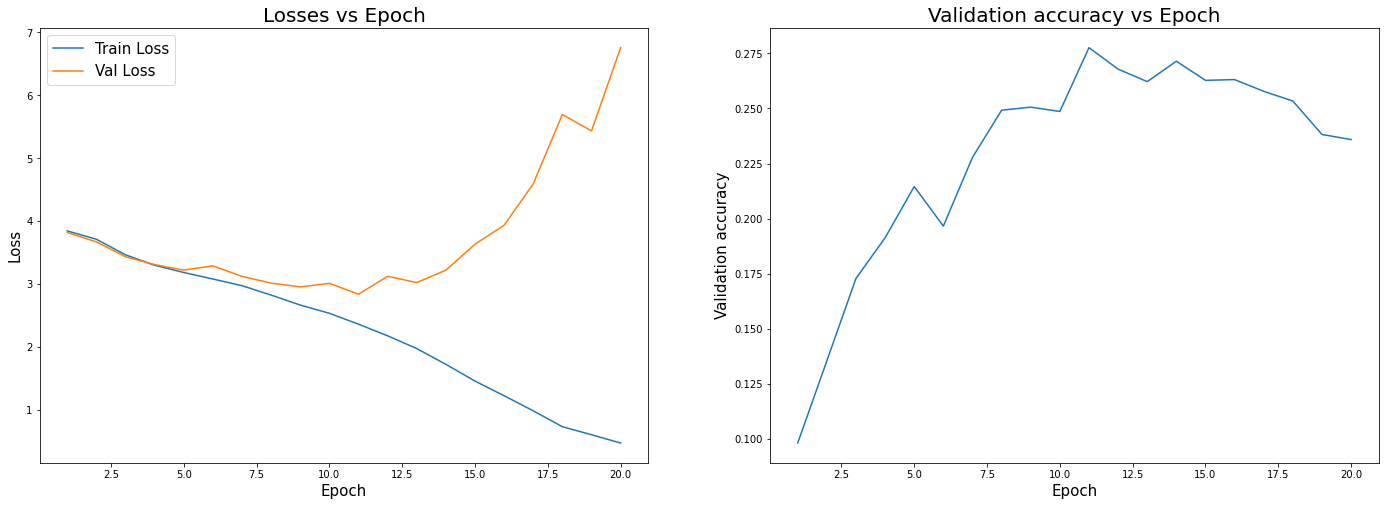

In [ ]:
plot_graphs(history)

# Dropout

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(512, 62)
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): Dropout(p=0.4, inplace=False)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.7588577270507812, Validation loss: 3.4702868461608887, Validation accuracy: 0.16527776420116425



Epoch: 2, Train loss: 3.3449056148529053, Validation loss: 3.2922985553741455, Validation accuracy: 0.2015046328306198



Epoch: 3, Train loss: 3.1567771434783936, Validation loss: 3.134474039077759, Validation accuracy: 0.21724537014961243



Epoch: 4, Train loss: 3.024395704269409, Validation loss: 3.0552663803100586, Validation accuracy: 0.237847238779068



Epoch: 5, Train loss: 2.896204710006714, Validation loss: 3.0342774391174316, Validation accuracy: 0.23726850748062134



Epoch: 6, Train loss: 2.7245516777038574, Validation loss: 2.9525108337402344, Validation accuracy: 0.2447916716337204



Epoch: 7, Train loss: 2.5579094886779785, Validation loss: 2.9126439094543457, Validation accuracy: 0.267245352268219



Epoch: 8, Train loss: 2.3754780292510986, Validation loss: 2.9024837017059326, Validation accuracy: 0.26620370149612427



Epoch: 9, Train loss: 2.1804094314575195, Validation loss: 2.97159743309021, Validation accuracy: 0.24849537014961243



Epoch: 10, Train loss: 1.9700695276260376, Validation loss: 2.992760181427002, Validation accuracy: 0.26006942987442017



Epoch: 11, Train loss: 1.739863395690918, Validation loss: 3.2219367027282715, Validation accuracy: 0.2535879611968994



Epoch: 12, Train loss: 1.5344973802566528, Validation loss: 3.113173484802246, Validation accuracy: 0.25995370745658875



Epoch: 13, Train loss: 1.3431211709976196, Validation loss: 3.3884048461914062, Validation accuracy: 0.25891202688217163



Epoch: 14, Train loss: 1.1410062313079834, Validation loss: 3.5805020332336426, Validation accuracy: 0.25138890743255615



Epoch: 15, Train loss: 1.0057811737060547, Validation loss: 3.7438621520996094, Validation accuracy: 0.2549768388271332



Epoch: 16, Train loss: 0.855600893497467, Validation loss: 3.9227209091186523, Validation accuracy: 0.25486108660697937



Epoch: 17, Train loss: 0.7178280353546143, Validation loss: 4.095944881439209, Validation accuracy: 0.26435184478759766



Epoch: 18, Train loss: 0.6325216889381409, Validation loss: 4.478621482849121, Validation accuracy: 0.23148149251937866



Epoch: 19, Train loss: 0.559575080871582, Validation loss: 4.401404857635498, Validation accuracy: 0.25312501192092896



Epoch: 20, Train loss: 0.49275797605514526, Validation loss: 4.7797722816467285, Validation accuracy: 0.25729167461395264



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.7588577270507812	Val loss:  3.4702868461608887	Val acc: 0.16527776420116425
Epoch: 2	Train loss: 3.3449056148529053	Val loss:  3.2922985553741455	Val acc: 0.2015046328306198
Epoch: 3	Train loss: 3.1567771434783936	Val loss:  3.134474039077759	Val acc: 0.21724537014961243
Epoch: 4	Train loss: 3.024395704269409	Val loss:  3.0552663803100586	Val acc: 0.237847238779068
Epoch: 5	Train loss: 2.896204710006714	Val loss:  3.0342774391174316	Val acc: 0.23726850748062134
Epoch: 6	Train loss: 2.7245516777038574	Val loss:  2.9525108337402344	Val acc: 0.2447916716337204
Epoch: 7	Train loss: 2.5579094886779785	Val loss:  2.9126439094543457	Val acc: 0.267245352268219
Epoch: 8	Train loss: 2.3754780292510986	Val loss:  2.9024837017059326	Val acc: 0.26620370149612427
Epoch: 9	Train loss: 2.1804094314575195	Val loss:  2.97159743309021	Val acc: 0.24849537014961243
Epoch: 10	Train loss: 1.9700695276260376	Val loss:  2.992760181427002	Val acc: 0.26006942987442017
Epoch: 11	Train loss:

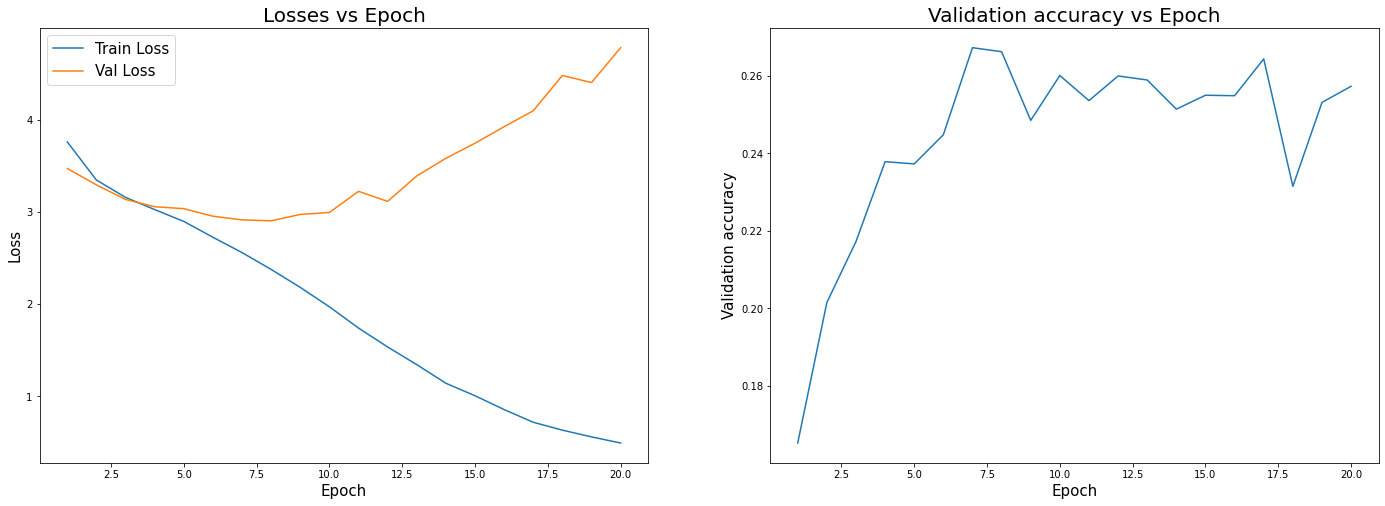

In [ ]:
plot_graphs(history)

# Different activation functions at the end

### Sigmoid activation function

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Sigmoid()
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.9426326751708984, Validation loss: 3.9405677318573, Validation accuracy: 0.09826388210058212



Epoch: 2, Train loss: 3.9398906230926514, Validation loss: 3.935706615447998, Validation accuracy: 0.09988425672054291



Epoch: 3, Train loss: 3.940854787826538, Validation loss: 3.9397575855255127, Validation accuracy: 0.09826388210058212



Epoch: 4, Train loss: 3.9379634857177734, Validation loss: 3.9381370544433594, Validation accuracy: 0.09826388210058212



Epoch: 5, Train loss: 3.938926935195923, Validation loss: 3.9324657917022705, Validation accuracy: 0.10150463134050369



Epoch: 6, Train loss: 3.9379634857177734, Validation loss: 3.9397575855255127, Validation accuracy: 0.09826388210058212



Epoch: 7, Train loss: 3.938926935195923, Validation loss: 3.936516761779785, Validation accuracy: 0.10150463134050369



Epoch: 8, Train loss: 3.9379634857177734, Validation loss: 3.9389472007751465, Validation accuracy: 0.09745370596647263



Epoch: 9, Train loss: 3.938926935195923, Validation loss: 3.935706853866577, Validation accuracy: 0.09826388210058212



Epoch: 10, Train loss: 3.9379634857177734, Validation loss: 3.935706615447998, Validation accuracy: 0.09826388210058212



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.9426326751708984	Val loss:  3.9405677318573	Val acc: 0.09826388210058212
Epoch: 2	Train loss: 3.9398906230926514	Val loss:  3.935706615447998	Val acc: 0.09988425672054291
Epoch: 3	Train loss: 3.940854787826538	Val loss:  3.9397575855255127	Val acc: 0.09826388210058212
Epoch: 4	Train loss: 3.9379634857177734	Val loss:  3.9381370544433594	Val acc: 0.09826388210058212
Epoch: 5	Train loss: 3.938926935195923	Val loss:  3.9324657917022705	Val acc: 0.10150463134050369
Epoch: 6	Train loss: 3.9379634857177734	Val loss:  3.9397575855255127	Val acc: 0.09826388210058212
Epoch: 7	Train loss: 3.938926935195923	Val loss:  3.936516761779785	Val acc: 0.10150463134050369
Epoch: 8	Train loss: 3.9379634857177734	Val loss:  3.9389472007751465	Val acc: 0.09745370596647263
Epoch: 9	Train loss: 3.938926935195923	Val loss:  3.935706853866577	Val acc: 0.09826388210058212
Epoch: 10	Train loss: 3.9379634857177734	Val loss:  3.935706615447998	Val acc: 0.09826388210058212


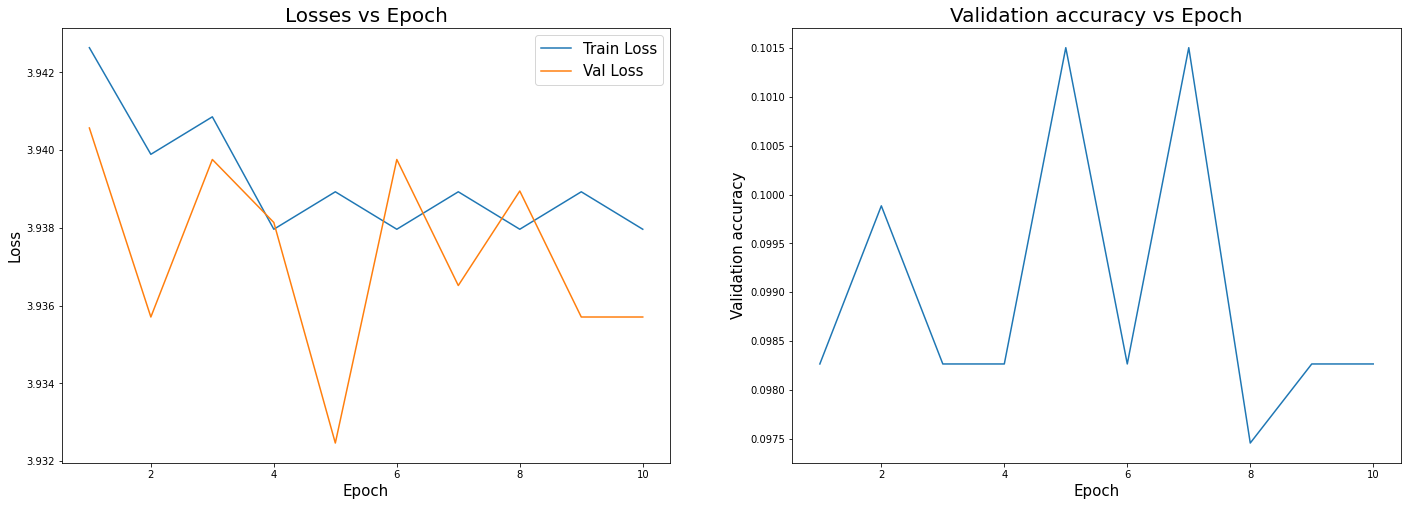

In [ ]:
plot_graphs(history)

### LogSigmoid activation function

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62),
            nn.LogSigmoid()
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): LogSigmoid()
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.739628314971924, Validation loss: 3.5548691749572754, Validation accuracy: 0.0807870402932167



Epoch: 2, Train loss: 3.3021059036254883, Validation loss: 3.268944263458252, Validation accuracy: 0.20000000298023224



Epoch: 3, Train loss: 2.9448506832122803, Validation loss: 3.0579240322113037, Validation accuracy: 0.2326388955116272



Epoch: 4, Train loss: 2.667083263397217, Validation loss: 3.0154972076416016, Validation accuracy: 0.23541666567325592



Epoch: 5, Train loss: 2.3064627647399902, Validation loss: 2.9773666858673096, Validation accuracy: 0.2637731432914734



Epoch: 6, Train loss: 1.8835482597351074, Validation loss: 3.1333975791931152, Validation accuracy: 0.26863425970077515



Epoch: 7, Train loss: 1.3520647287368774, Validation loss: 3.527575969696045, Validation accuracy: 0.2562499940395355



Epoch: 8, Train loss: 0.8465397953987122, Validation loss: 3.9931178092956543, Validation accuracy: 0.2552083432674408



Epoch: 9, Train loss: 0.4778692424297333, Validation loss: 4.698664665222168, Validation accuracy: 0.22881942987442017



Epoch: 10, Train loss: 0.2862509787082672, Validation loss: 5.158344745635986, Validation accuracy: 0.24016204476356506



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.739628314971924	Val loss:  3.5548691749572754	Val acc: 0.0807870402932167
Epoch: 2	Train loss: 3.3021059036254883	Val loss:  3.268944263458252	Val acc: 0.20000000298023224
Epoch: 3	Train loss: 2.9448506832122803	Val loss:  3.0579240322113037	Val acc: 0.2326388955116272
Epoch: 4	Train loss: 2.667083263397217	Val loss:  3.0154972076416016	Val acc: 0.23541666567325592
Epoch: 5	Train loss: 2.3064627647399902	Val loss:  2.9773666858673096	Val acc: 0.2637731432914734
Epoch: 6	Train loss: 1.8835482597351074	Val loss:  3.1333975791931152	Val acc: 0.26863425970077515
Epoch: 7	Train loss: 1.3520647287368774	Val loss:  3.527575969696045	Val acc: 0.2562499940395355
Epoch: 8	Train loss: 0.8465397953987122	Val loss:  3.9931178092956543	Val acc: 0.2552083432674408
Epoch: 9	Train loss: 0.4778692424297333	Val loss:  4.698664665222168	Val acc: 0.22881942987442017
Epoch: 10	Train loss: 0.2862509787082672	Val loss:  5.158344745635986	Val acc: 0.24016204476356506


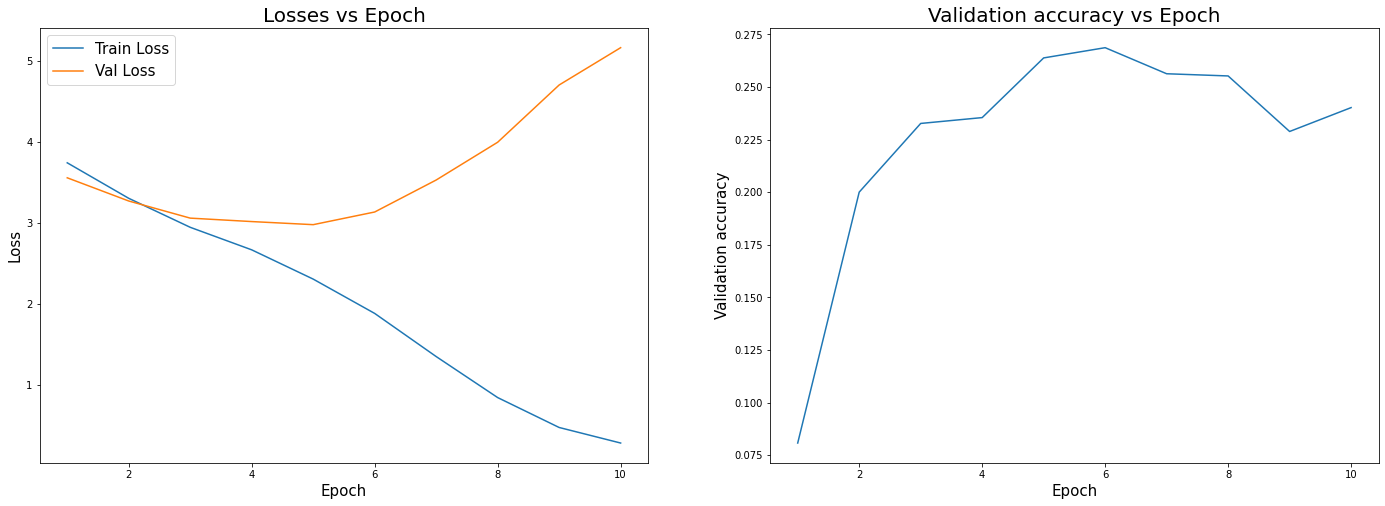

In [ ]:
plot_graphs(history)

### Softmax activation function

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62),
            nn.Softmax()
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Softmax(dim=None)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Epoch: 1, Train loss: 4.097652435302734, Validation loss: 4.098106384277344, Validation accuracy: 0.056365739554166794



Epoch: 2, Train loss: 4.097179889678955, Validation loss: 4.099726676940918, Validation accuracy: 0.054745372384786606



Epoch: 3, Train loss: 4.097179889678955, Validation loss: 4.098916530609131, Validation accuracy: 0.0555555559694767



Epoch: 4, Train loss: 4.096216678619385, Validation loss: 4.101346969604492, Validation accuracy: 0.05312500149011612



Epoch: 5, Train loss: 4.097179889678955, Validation loss: 4.100536823272705, Validation accuracy: 0.05393518507480621



Epoch: 6, Train loss: 4.097179889678955, Validation loss: 4.099726676940918, Validation accuracy: 0.054745372384786606



Epoch: 7, Train loss: 4.096216678619385, Validation loss: 4.100536823272705, Validation accuracy: 0.05393518507480621



Epoch: 8, Train loss: 4.097179889678955, Validation loss: 4.100536823272705, Validation accuracy: 0.05393518507480621



Epoch: 9, Train loss: 4.096216678619385, Validation loss: 4.098916530609131, Validation accuracy: 0.055555559694767



Epoch: 10, Train loss: 4.097179889678955, Validation loss: 4.100536823272705, Validation accuracy: 0.05393518507480621



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 4.097652435302734	Val loss:  4.098106384277344	Val acc: 0.056365739554166794
Epoch: 2	Train loss: 4.097179889678955	Val loss:  4.099726676940918	Val acc: 0.054745372384786606
Epoch: 3	Train loss: 4.097179889678955	Val loss:  4.098916530609131	Val acc: 0.0555555559694767
Epoch: 4	Train loss: 4.096216678619385	Val loss:  4.101346969604492	Val acc: 0.05312500149011612
Epoch: 5	Train loss: 4.097179889678955	Val loss:  4.100536823272705	Val acc: 0.05393518507480621
Epoch: 6	Train loss: 4.097179889678955	Val loss:  4.099726676940918	Val acc: 0.054745372384786606
Epoch: 7	Train loss: 4.096216678619385	Val loss:  4.100536823272705	Val acc: 0.05393518507480621
Epoch: 8	Train loss: 4.097179889678955	Val loss:  4.100536823272705	Val acc: 0.05393518507480621
Epoch: 9	Train loss: 4.096216678619385	Val loss:  4.098916530609131	Val acc: 0.055555559694767
Epoch: 10	Train loss: 4.097179889678955	Val loss:  4.100536823272705	Val acc: 0.05393518507480621


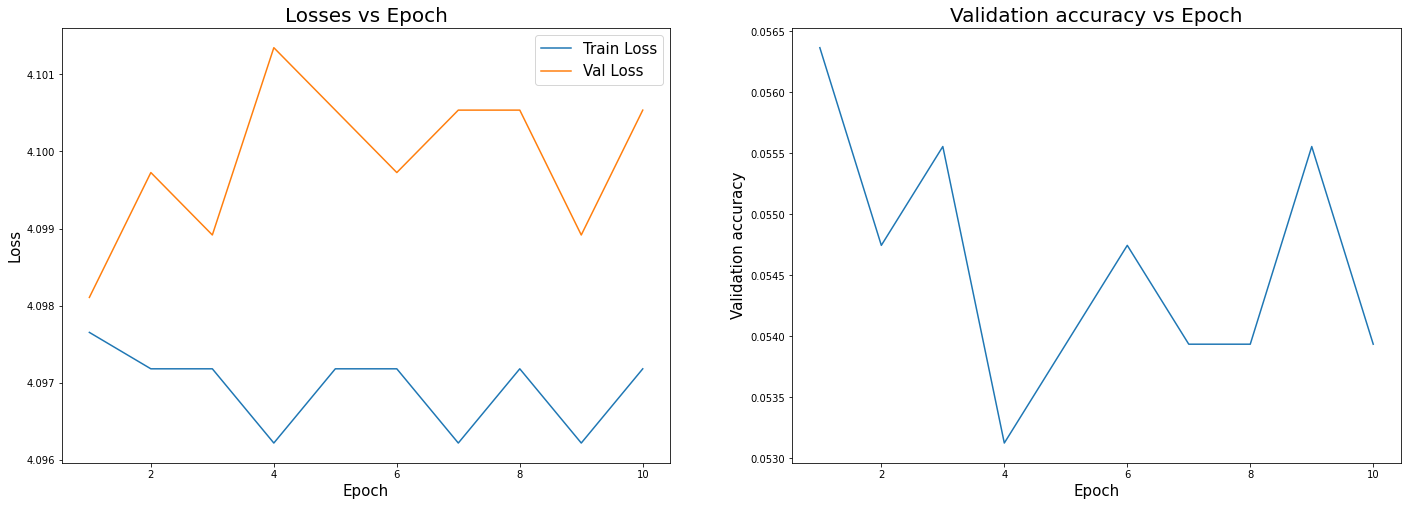

In [ ]:
plot_graphs(history)

### LogSoftmax activation function

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): LogSoftmax(dim=None)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Epoch: 1, Train loss: 3.757093906402588, Validation loss: 3.5025219917297363, Validation accuracy: 0.14976851642131805



Epoch: 2, Train loss: 3.297844648361206, Validation loss: 3.2799291610717773, Validation accuracy: 0.1969907432794571



Epoch: 3, Train loss: 3.011723518371582, Validation loss: 3.1510562896728516, Validation accuracy: 0.21886573731899261



Epoch: 4, Train loss: 2.8015968799591064, Validation loss: 2.9973435401916504, Validation accuracy: 0.2457175850868225



Epoch: 5, Train loss: 2.5465383529663086, Validation loss: 2.9979331493377686, Validation accuracy: 0.2422453761100769



Epoch: 6, Train loss: 2.2963738441467285, Validation loss: 2.9432268142700195, Validation accuracy: 0.2655092477798462



Epoch: 7, Train loss: 1.9731173515319824, Validation loss: 3.0977916717529297, Validation accuracy: 0.26875001192092896



Epoch: 8, Train loss: 1.5806059837341309, Validation loss: 3.3784618377685547, Validation accuracy: 0.23807869851589203



Epoch: 9, Train loss: 1.1591668128967285, Validation loss: 3.6364803314208984, Validation accuracy: 0.2516203820705414



Epoch: 10, Train loss: 0.7953247427940369, Validation loss: 4.315735816955566, Validation accuracy: 0.24664351344108582



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.757093906402588	Val loss:  3.5025219917297363	Val acc: 0.14976851642131805
Epoch: 2	Train loss: 3.297844648361206	Val loss:  3.2799291610717773	Val acc: 0.1969907432794571
Epoch: 3	Train loss: 3.011723518371582	Val loss:  3.1510562896728516	Val acc: 0.21886573731899261
Epoch: 4	Train loss: 2.8015968799591064	Val loss:  2.9973435401916504	Val acc: 0.2457175850868225
Epoch: 5	Train loss: 2.5465383529663086	Val loss:  2.9979331493377686	Val acc: 0.2422453761100769
Epoch: 6	Train loss: 2.2963738441467285	Val loss:  2.9432268142700195	Val acc: 0.2655092477798462
Epoch: 7	Train loss: 1.9731173515319824	Val loss:  3.0977916717529297	Val acc: 0.26875001192092896
Epoch: 8	Train loss: 1.5806059837341309	Val loss:  3.3784618377685547	Val acc: 0.23807869851589203
Epoch: 9	Train loss: 1.1591668128967285	Val loss:  3.6364803314208984	Val acc: 0.2516203820705414
Epoch: 10	Train loss: 0.7953247427940369	Val loss:  4.315735816955566	Val acc: 0.24664351344108582


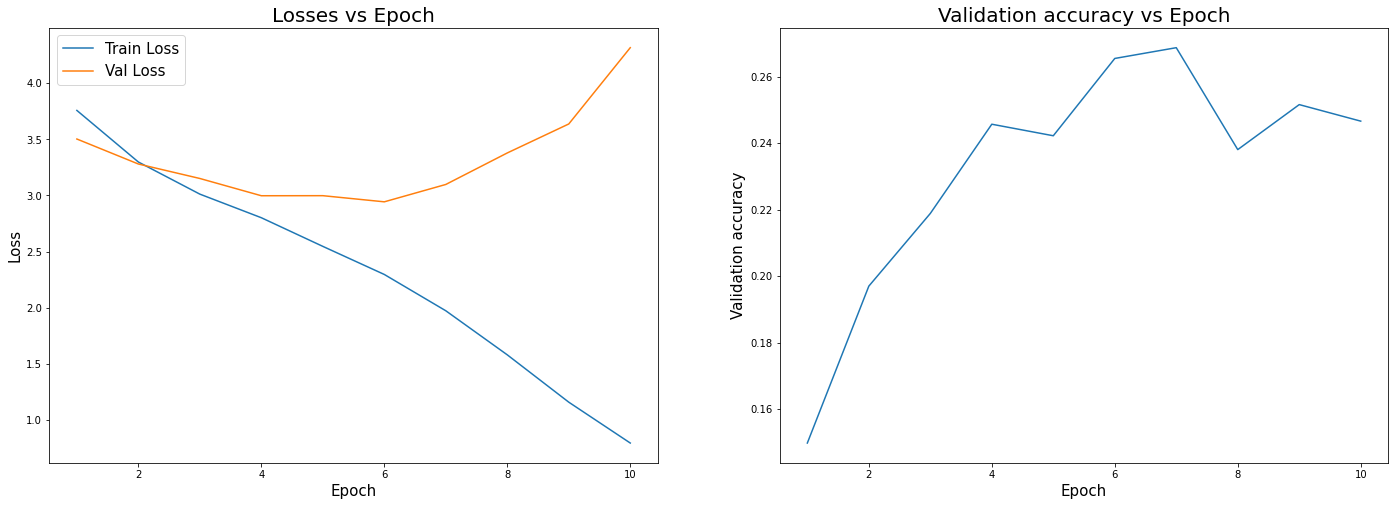

In [ ]:
plot_graphs(history)

### Tanh activation function

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62),
            nn.Tanh()
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Tanh()
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.7002906799316406, Validation loss: 3.5949606895446777, Validation accuracy: 0.08287037163972855



Epoch: 2, Train loss: 3.4745373725891113, Validation loss: 3.46462345123291, Validation accuracy: 0.1770833283662796



Epoch: 3, Train loss: 3.3415639400482178, Validation loss: 3.3996472358703613, Validation accuracy: 0.2127314954996109



Epoch: 4, Train loss: 3.2392771244049072, Validation loss: 3.3795313835144043, Validation accuracy: 0.2370370328426361



Epoch: 5, Train loss: 3.1411473751068115, Validation loss: 3.3674206733703613, Validation accuracy: 0.23541666567325592



Epoch: 6, Train loss: 3.0606746673583984, Validation loss: 3.340700387954712, Validation accuracy: 0.25833332538604736



Epoch: 7, Train loss: 2.97961163520813, Validation loss: 3.359196186065674, Validation accuracy: 0.2657407522201538



Epoch: 8, Train loss: 2.9149301052093506, Validation loss: 3.375831127166748, Validation accuracy: 0.2614583373069763



Epoch: 9, Train loss: 2.8451497554779053, Validation loss: 3.367065906524658, Validation accuracy: 0.2612268328666687



Epoch: 10, Train loss: 2.780275344848633, Validation loss: 3.3560941219329834, Validation accuracy: 0.2545138895511627



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.7002906799316406	Val loss:  3.5949606895446777	Val acc: 0.08287037163972855
Epoch: 2	Train loss: 3.4745373725891113	Val loss:  3.46462345123291	Val acc: 0.1770833283662796
Epoch: 3	Train loss: 3.3415639400482178	Val loss:  3.3996472358703613	Val acc: 0.2127314954996109
Epoch: 4	Train loss: 3.2392771244049072	Val loss:  3.3795313835144043	Val acc: 0.2370370328426361
Epoch: 5	Train loss: 3.1411473751068115	Val loss:  3.3674206733703613	Val acc: 0.23541666567325592
Epoch: 6	Train loss: 3.0606746673583984	Val loss:  3.340700387954712	Val acc: 0.25833332538604736
Epoch: 7	Train loss: 2.97961163520813	Val loss:  3.359196186065674	Val acc: 0.2657407522201538
Epoch: 8	Train loss: 2.9149301052093506	Val loss:  3.375831127166748	Val acc: 0.2614583373069763
Epoch: 9	Train loss: 2.8451497554779053	Val loss:  3.367065906524658	Val acc: 0.2612268328666687
Epoch: 10	Train loss: 2.780275344848633	Val loss:  3.3560941219329834	Val acc: 0.2545138895511627


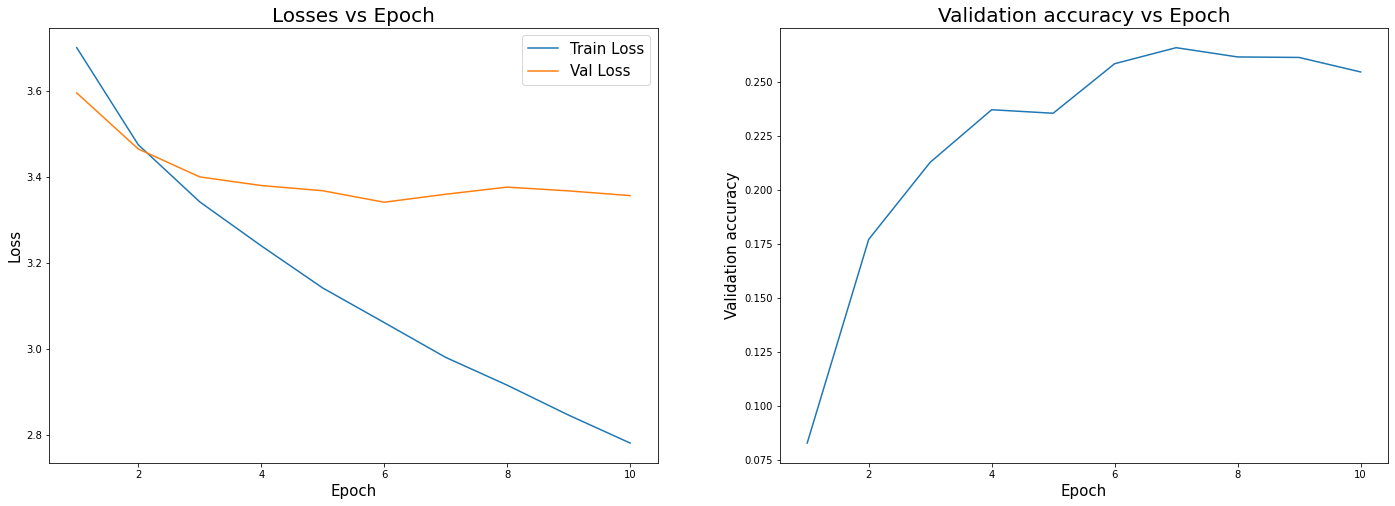

In [ ]:
plot_graphs(history)

### Exponential Linear Unit (ELU)

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62),
            nn.ELU()
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): ELU(alpha=1.0)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.67392635345459, Validation loss: 3.381145477294922, Validation accuracy: 0.20636574923992157



Epoch: 2, Train loss: 3.126939296722412, Validation loss: 3.2107577323913574, Validation accuracy: 0.22685185074806213



Epoch: 3, Train loss: 2.899552822113037, Validation loss: 2.951664924621582, Validation accuracy: 0.2612268328666687



Epoch: 4, Train loss: 2.6076202392578125, Validation loss: 2.9674627780914307, Validation accuracy: 0.2629629671573639



Epoch: 5, Train loss: 2.3472883701324463, Validation loss: 2.9468727111816406, Validation accuracy: 0.25127315521240234



Epoch: 6, Train loss: 1.991278052330017, Validation loss: 2.9635159969329834, Validation accuracy: 0.27650463581085205



Epoch: 7, Train loss: 1.596384048461914, Validation loss: 3.0492169857025146, Validation accuracy: 0.28078702092170715



Epoch: 8, Train loss: 1.1487948894500732, Validation loss: 3.680589437484741, Validation accuracy: 0.26620370149612427



Epoch: 9, Train loss: 0.7937085032463074, Validation loss: 3.7950751781463623, Validation accuracy: 0.2562499940395355



Epoch: 10, Train loss: 0.44273459911346436, Validation loss: 4.249275207519531, Validation accuracy: 0.2646990716457367



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.67392635345459	Val loss:  3.381145477294922	Val acc: 0.20636574923992157
Epoch: 2	Train loss: 3.126939296722412	Val loss:  3.2107577323913574	Val acc: 0.22685185074806213
Epoch: 3	Train loss: 2.899552822113037	Val loss:  2.951664924621582	Val acc: 0.2612268328666687
Epoch: 4	Train loss: 2.6076202392578125	Val loss:  2.9674627780914307	Val acc: 0.2629629671573639
Epoch: 5	Train loss: 2.3472883701324463	Val loss:  2.9468727111816406	Val acc: 0.25127315521240234
Epoch: 6	Train loss: 1.991278052330017	Val loss:  2.9635159969329834	Val acc: 0.27650463581085205
Epoch: 7	Train loss: 1.596384048461914	Val loss:  3.0492169857025146	Val acc: 0.28078702092170715
Epoch: 8	Train loss: 1.1487948894500732	Val loss:  3.680589437484741	Val acc: 0.26620370149612427
Epoch: 9	Train loss: 0.7937085032463074	Val loss:  3.7950751781463623	Val acc: 0.2562499940395355
Epoch: 10	Train loss: 0.44273459911346436	Val loss:  4.249275207519531	Val acc: 0.2646990716457367


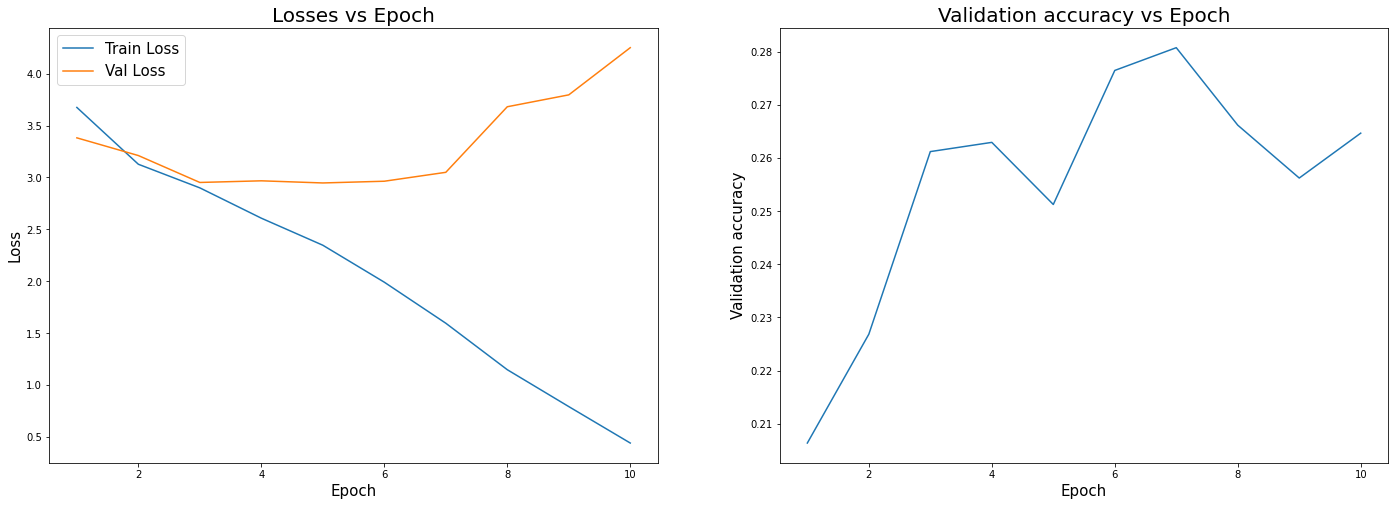

In [ ]:
plot_graphs(history)

### Rectified Linear Unit (ReLU)

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62),
            nn.ReLU()
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): ReLU()
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.930849075317383, Validation loss: 3.7105023860931396, Validation accuracy: 0.1648148149251938



Epoch: 2, Train loss: 3.639716148376465, Validation loss: 3.5850183963775635, Validation accuracy: 0.20462962985038757



Epoch: 3, Train loss: 3.556999444961548, Validation loss: 3.566721200942993, Validation accuracy: 0.20381943881511688



Epoch: 4, Train loss: 3.5110766887664795, Validation loss: 3.550445318222046, Validation accuracy: 0.20972223579883575



Epoch: 5, Train loss: 3.465085029602051, Validation loss: 3.566462278366089, Validation accuracy: 0.21689815819263458



Epoch: 6, Train loss: 3.421351671218872, Validation loss: 3.5310258865356445, Validation accuracy: 0.22175925970077515



Epoch: 7, Train loss: 3.3612897396087646, Validation loss: 3.5136752128601074, Validation accuracy: 0.2318287044763565



Epoch: 8, Train loss: 3.298110246658325, Validation loss: 3.5085551738739014, Validation accuracy: 0.23078703880310059



Epoch: 9, Train loss: 3.214963912963867, Validation loss: 3.5413079261779785, Validation accuracy: 0.21921296417713165



Epoch: 10, Train loss: 3.0950989723205566, Validation loss: 3.5793302059173584, Validation accuracy: 0.20879629254341125



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.930849075317383	Val loss:  3.7105023860931396	Val acc: 0.1648148149251938
Epoch: 2	Train loss: 3.639716148376465	Val loss:  3.5850183963775635	Val acc: 0.20462962985038757
Epoch: 3	Train loss: 3.556999444961548	Val loss:  3.566721200942993	Val acc: 0.20381943881511688
Epoch: 4	Train loss: 3.5110766887664795	Val loss:  3.550445318222046	Val acc: 0.20972223579883575
Epoch: 5	Train loss: 3.465085029602051	Val loss:  3.566462278366089	Val acc: 0.21689815819263458
Epoch: 6	Train loss: 3.421351671218872	Val loss:  3.5310258865356445	Val acc: 0.22175925970077515
Epoch: 7	Train loss: 3.3612897396087646	Val loss:  3.5136752128601074	Val acc: 0.2318287044763565
Epoch: 8	Train loss: 3.298110246658325	Val loss:  3.5085551738739014	Val acc: 0.23078703880310059
Epoch: 9	Train loss: 3.214963912963867	Val loss:  3.5413079261779785	Val acc: 0.21921296417713165
Epoch: 10	Train loss: 3.0950989723205566	Val loss:  3.5793302059173584	Val acc: 0.20879629254341125


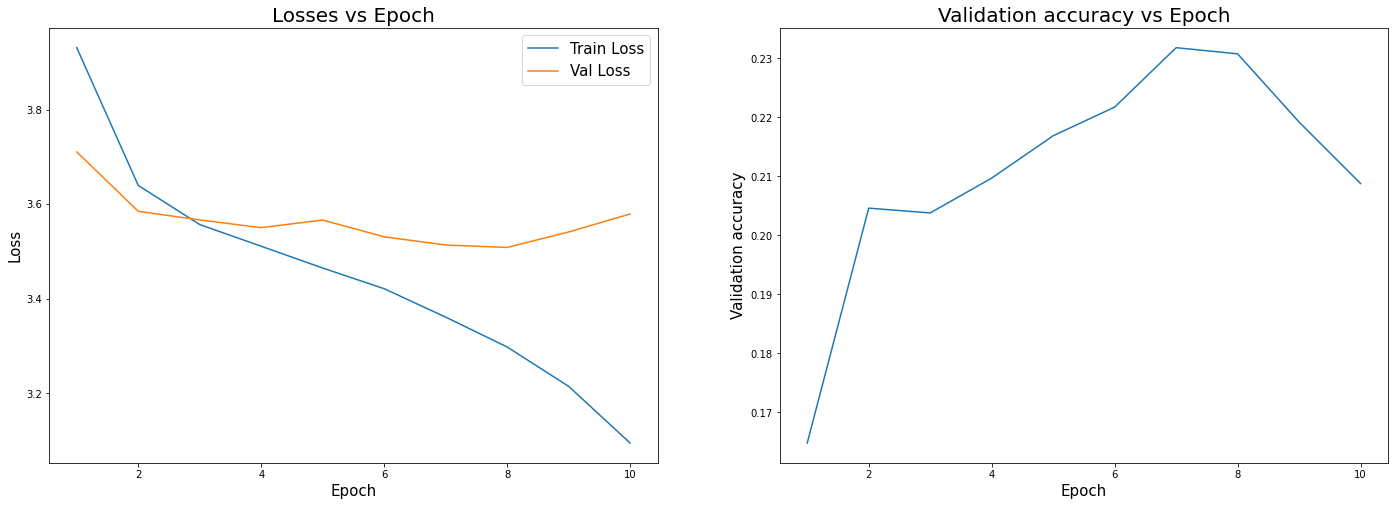

In [ ]:
plot_graphs(history)

# Different pooling stategies

### Max Pooling

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62)
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.8009023666381836, Validation loss: 3.5452396869659424, Validation accuracy: 0.17476850748062134



Epoch: 2, Train loss: 3.293173313140869, Validation loss: 3.2278521060943604, Validation accuracy: 0.20358796417713165



Epoch: 3, Train loss: 3.0353925228118896, Validation loss: 3.179802417755127, Validation accuracy: 0.22337962687015533



Epoch: 4, Train loss: 2.885687828063965, Validation loss: 3.02030086517334, Validation accuracy: 0.23935183882713318



Epoch: 5, Train loss: 2.690101385116577, Validation loss: 3.0244717597961426, Validation accuracy: 0.23414351046085358



Epoch: 6, Train loss: 2.4279983043670654, Validation loss: 2.962477445602417, Validation accuracy: 0.25833332538604736



Epoch: 7, Train loss: 2.0780863761901855, Validation loss: 3.1826560497283936, Validation accuracy: 0.24085648357868195



Epoch: 8, Train loss: 1.6704670190811157, Validation loss: 3.2556653022766113, Validation accuracy: 0.24363425374031067



Epoch: 9, Train loss: 1.2552039623260498, Validation loss: 3.736119270324707, Validation accuracy: 0.2359953671693802



Epoch: 10, Train loss: 0.8708454370498657, Validation loss: 4.165708065032959, Validation accuracy: 0.23564815521240234



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.8009023666381836	Val loss:  3.5452396869659424	Val acc: 0.17476850748062134
Epoch: 2	Train loss: 3.293173313140869	Val loss:  3.2278521060943604	Val acc: 0.20358796417713165
Epoch: 3	Train loss: 3.0353925228118896	Val loss:  3.179802417755127	Val acc: 0.22337962687015533
Epoch: 4	Train loss: 2.885687828063965	Val loss:  3.02030086517334	Val acc: 0.23935183882713318
Epoch: 5	Train loss: 2.690101385116577	Val loss:  3.0244717597961426	Val acc: 0.23414351046085358
Epoch: 6	Train loss: 2.4279983043670654	Val loss:  2.962477445602417	Val acc: 0.25833332538604736
Epoch: 7	Train loss: 2.0780863761901855	Val loss:  3.1826560497283936	Val acc: 0.24085648357868195
Epoch: 8	Train loss: 1.6704670190811157	Val loss:  3.2556653022766113	Val acc: 0.24363425374031067
Epoch: 9	Train loss: 1.2552039623260498	Val loss:  3.736119270324707	Val acc: 0.2359953671693802
Epoch: 10	Train loss: 0.8708454370498657	Val loss:  4.165708065032959	Val acc: 0.23564815521240234


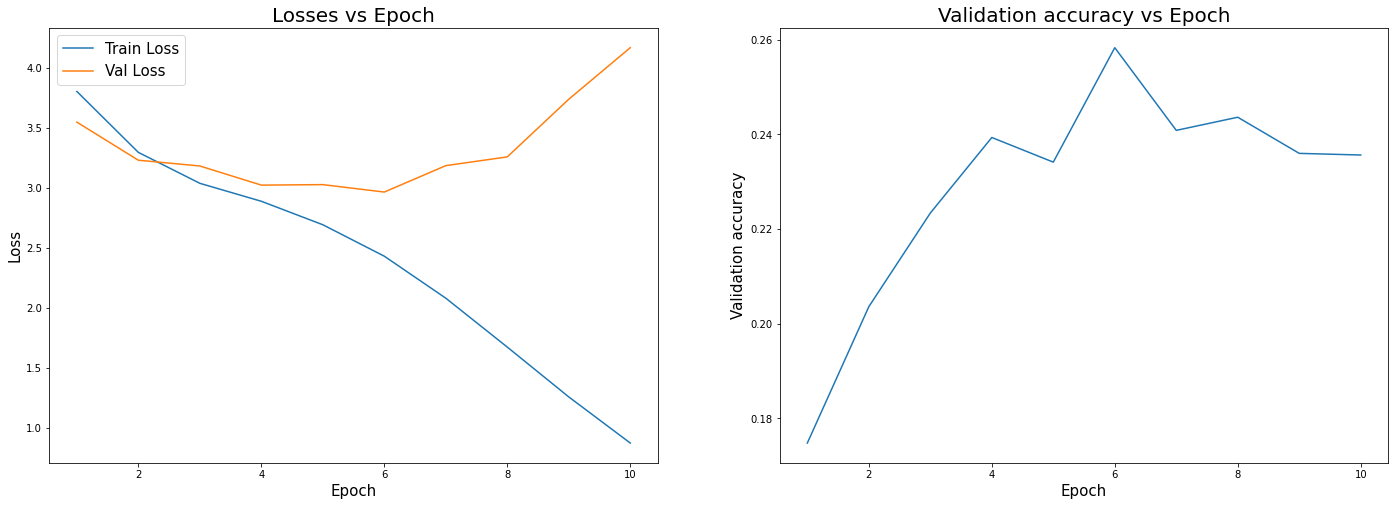

In [ ]:
plot_graphs(history)

### Average Pooling

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62)
        )

    def forward(self, x):
        return self.CNN(x)

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.5695390701293945, Validation loss: 3.296727180480957, Validation accuracy: 0.1944444328546524



Epoch: 2, Train loss: 3.107388973236084, Validation loss: 3.1994874477386475, Validation accuracy: 0.2179398238658905



Epoch: 3, Train loss: 2.892014265060425, Validation loss: 3.055555820465088, Validation accuracy: 0.23738425970077515



Epoch: 4, Train loss: 2.6656384468078613, Validation loss: 2.969367265701294, Validation accuracy: 0.2535879611968994



Epoch: 5, Train loss: 2.413893461227417, Validation loss: 3.007124900817871, Validation accuracy: 0.2716435194015503



Epoch: 6, Train loss: 2.089252471923828, Validation loss: 3.129155397415161, Validation accuracy: 0.25740739703178406



Epoch: 7, Train loss: 1.7173936367034912, Validation loss: 3.2840628623962402, Validation accuracy: 0.25914350152015686



Epoch: 8, Train loss: 1.3210734128952026, Validation loss: 3.6066837310791016, Validation accuracy: 0.25648149847984314



Epoch: 9, Train loss: 0.9398094415664673, Validation loss: 4.309243202209473, Validation accuracy: 0.2525462806224823



Epoch: 10, Train loss: 0.5754379034042358, Validation loss: 4.769662857055664, Validation accuracy: 0.2290509194135666



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.5695390701293945	Val loss:  3.296727180480957	Val acc: 0.1944444328546524
Epoch: 2	Train loss: 3.107388973236084	Val loss:  3.1994874477386475	Val acc: 0.2179398238658905
Epoch: 3	Train loss: 2.892014265060425	Val loss:  3.055555820465088	Val acc: 0.23738425970077515
Epoch: 4	Train loss: 2.6656384468078613	Val loss:  2.969367265701294	Val acc: 0.2535879611968994
Epoch: 5	Train loss: 2.413893461227417	Val loss:  3.007124900817871	Val acc: 0.2716435194015503
Epoch: 6	Train loss: 2.089252471923828	Val loss:  3.129155397415161	Val acc: 0.25740739703178406
Epoch: 7	Train loss: 1.7173936367034912	Val loss:  3.2840628623962402	Val acc: 0.25914350152015686
Epoch: 8	Train loss: 1.3210734128952026	Val loss:  3.6066837310791016	Val acc: 0.25648149847984314
Epoch: 9	Train loss: 0.9398094415664673	Val loss:  4.309243202209473	Val acc: 0.2525462806224823
Epoch: 10	Train loss: 0.5754379034042358	Val loss:  4.769662857055664	Val acc: 0.2290509194135666


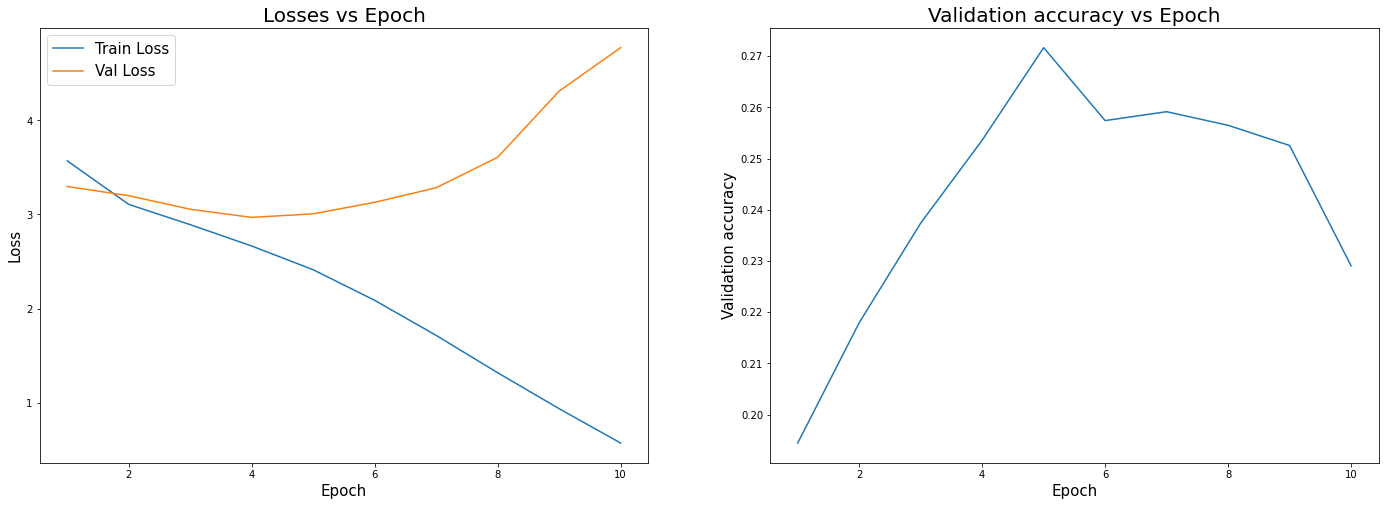

In [ ]:
plot_graphs(history)

# Different optimizers

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62)
        )

    def forward(self, x):
        return self.CNN(x)

### Adam optimizer

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.8009023666381836, Validation loss: 3.5452396869659424, Validation accuracy: 0.17476850748062134



Epoch: 2, Train loss: 3.293173313140869, Validation loss: 3.2278521060943604, Validation accuracy: 0.20358796417713165



Epoch: 3, Train loss: 3.0353925228118896, Validation loss: 3.179802417755127, Validation accuracy: 0.22337962687015533



Epoch: 4, Train loss: 2.885687828063965, Validation loss: 3.02030086517334, Validation accuracy: 0.23935183882713318



Epoch: 5, Train loss: 2.690101385116577, Validation loss: 3.0244717597961426, Validation accuracy: 0.23414351046085358



Epoch: 6, Train loss: 2.4279983043670654, Validation loss: 2.962477445602417, Validation accuracy: 0.25833332538604736



Epoch: 7, Train loss: 2.0780863761901855, Validation loss: 3.1826560497283936, Validation accuracy: 0.24085648357868195



Epoch: 8, Train loss: 1.6704670190811157, Validation loss: 3.2556653022766113, Validation accuracy: 0.24363425374031067



Epoch: 9, Train loss: 1.2552039623260498, Validation loss: 3.736119270324707, Validation accuracy: 0.2359953671693802



Epoch: 10, Train loss: 0.8708454370498657, Validation loss: 4.165708065032959, Validation accuracy: 0.23564815521240234



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.8009023666381836	Val loss:  3.5452396869659424	Val acc: 0.17476850748062134
Epoch: 2	Train loss: 3.293173313140869	Val loss:  3.2278521060943604	Val acc: 0.20358796417713165
Epoch: 3	Train loss: 3.0353925228118896	Val loss:  3.179802417755127	Val acc: 0.22337962687015533
Epoch: 4	Train loss: 2.885687828063965	Val loss:  3.02030086517334	Val acc: 0.23935183882713318
Epoch: 5	Train loss: 2.690101385116577	Val loss:  3.0244717597961426	Val acc: 0.23414351046085358
Epoch: 6	Train loss: 2.4279983043670654	Val loss:  2.962477445602417	Val acc: 0.25833332538604736
Epoch: 7	Train loss: 2.0780863761901855	Val loss:  3.1826560497283936	Val acc: 0.24085648357868195
Epoch: 8	Train loss: 1.6704670190811157	Val loss:  3.2556653022766113	Val acc: 0.24363425374031067
Epoch: 9	Train loss: 1.2552039623260498	Val loss:  3.736119270324707	Val acc: 0.2359953671693802
Epoch: 10	Train loss: 0.8708454370498657	Val loss:  4.165708065032959	Val acc: 0.23564815521240234


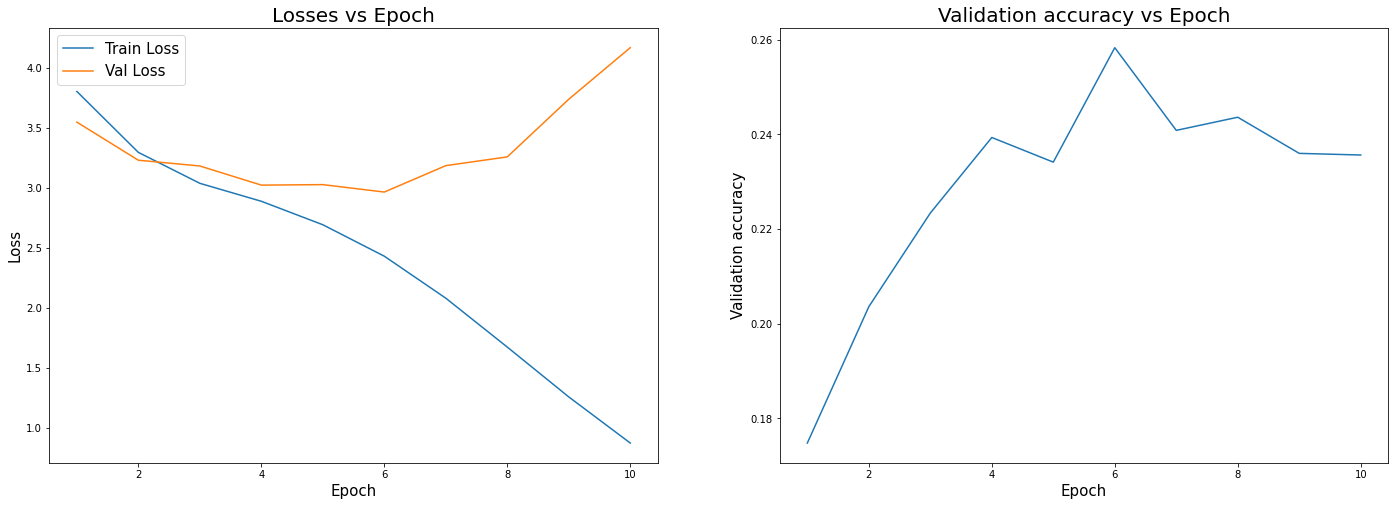

In [ ]:
plot_graphs(history)

### Adagrad optimizer

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adagrad
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.638272523880005, Validation loss: 3.4486865997314453, Validation accuracy: 0.151157408952713



Epoch: 2, Train loss: 3.2285070419311523, Validation loss: 3.725010871887207, Validation accuracy: 0.125



Epoch: 3, Train loss: 3.025132894515991, Validation loss: 3.2026877403259277, Validation accuracy: 0.23020833730697632



Epoch: 4, Train loss: 2.8799805641174316, Validation loss: 3.1705334186553955, Validation accuracy: 0.22233796119689941



Epoch: 5, Train loss: 2.7466585636138916, Validation loss: 3.145451307296753, Validation accuracy: 0.23564815521240234



Epoch: 6, Train loss: 2.6298587322235107, Validation loss: 3.2431492805480957, Validation accuracy: 0.22442129254341125



Epoch: 7, Train loss: 2.54948091506958, Validation loss: 3.1722724437713623, Validation accuracy: 0.22557871043682098



Epoch: 8, Train loss: 2.4479458332061768, Validation loss: 3.0721211433410645, Validation accuracy: 0.23726850748062134



Epoch: 9, Train loss: 2.3698978424072266, Validation loss: 3.023206949234009, Validation accuracy: 0.2516203820705414



Epoch: 10, Train loss: 2.2945408821105957, Validation loss: 3.039752960205078, Validation accuracy: 0.2533564865589142



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.638272523880005	Val loss:  3.4486865997314453	Val acc: 0.151157408952713
Epoch: 2	Train loss: 3.2285070419311523	Val loss:  3.725010871887207	Val acc: 0.125
Epoch: 3	Train loss: 3.025132894515991	Val loss:  3.2026877403259277	Val acc: 0.23020833730697632
Epoch: 4	Train loss: 2.8799805641174316	Val loss:  3.1705334186553955	Val acc: 0.22233796119689941
Epoch: 5	Train loss: 2.7466585636138916	Val loss:  3.145451307296753	Val acc: 0.23564815521240234
Epoch: 6	Train loss: 2.6298587322235107	Val loss:  3.2431492805480957	Val acc: 0.22442129254341125
Epoch: 7	Train loss: 2.54948091506958	Val loss:  3.1722724437713623	Val acc: 0.22557871043682098
Epoch: 8	Train loss: 2.4479458332061768	Val loss:  3.0721211433410645	Val acc: 0.23726850748062134
Epoch: 9	Train loss: 2.3698978424072266	Val loss:  3.023206949234009	Val acc: 0.2516203820705414
Epoch: 10	Train loss: 2.2945408821105957	Val loss:  3.039752960205078	Val acc: 0.2533564865589142


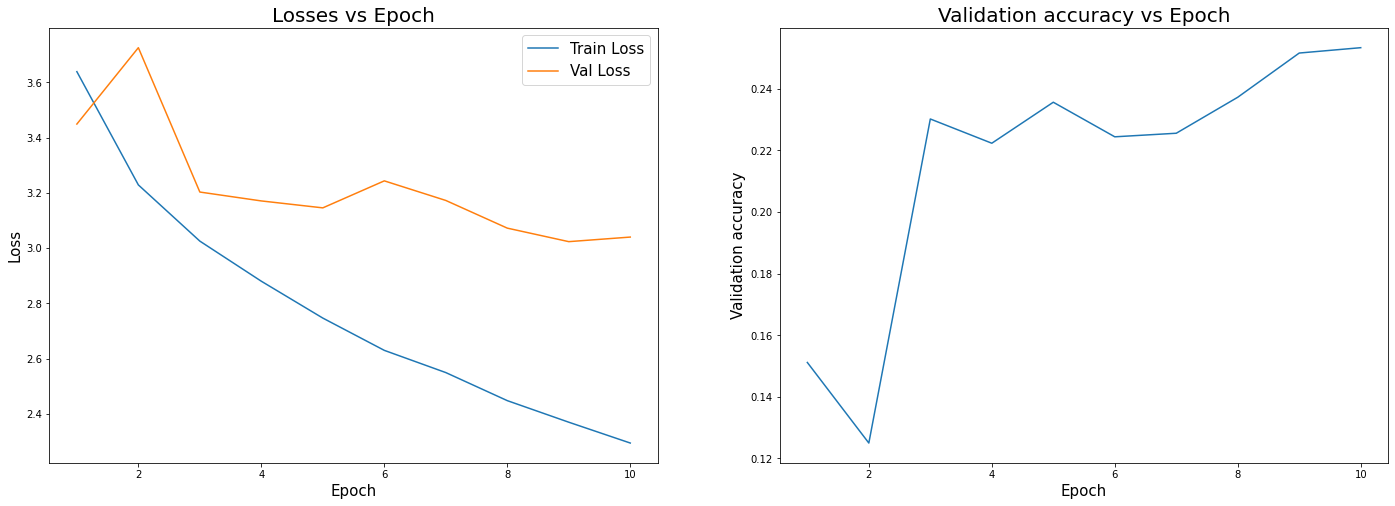

In [ ]:
plot_graphs(history)

### Adadelta optimizer

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adadelta
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 4.034656524658203, Validation loss: 3.944812297821045, Validation accuracy: 0.09907408058643341



Epoch: 2, Train loss: 3.8879477977752686, Validation loss: 3.853069305419922, Validation accuracy: 0.09907408058643341



Epoch: 3, Train loss: 3.8315744400024414, Validation loss: 3.8161959648132324, Validation accuracy: 0.09826388210058212



Epoch: 4, Train loss: 3.804443359375, Validation loss: 3.7986037731170654, Validation accuracy: 0.09907408058643341



Epoch: 5, Train loss: 3.789989709854126, Validation loss: 3.796929121017456, Validation accuracy: 0.09988425672054291



Epoch: 6, Train loss: 3.776458501815796, Validation loss: 3.7957451343536377, Validation accuracy: 0.09664352238178253



Epoch: 7, Train loss: 3.7703752517700195, Validation loss: 3.7853827476501465, Validation accuracy: 0.09745370596647263



Epoch: 8, Train loss: 3.7669239044189453, Validation loss: 3.7804763317108154, Validation accuracy: 0.09907408058643341



Epoch: 9, Train loss: 3.762171745300293, Validation loss: 3.7760703563690186, Validation accuracy: 0.09826388210058212



Epoch: 10, Train loss: 3.755606174468994, Validation loss: 3.7671077251434326, Validation accuracy: 0.09826388210058212



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 4.034656524658203	Val loss:  3.944812297821045	Val acc: 0.09907408058643341
Epoch: 2	Train loss: 3.8879477977752686	Val loss:  3.853069305419922	Val acc: 0.09907408058643341
Epoch: 3	Train loss: 3.8315744400024414	Val loss:  3.8161959648132324	Val acc: 0.09826388210058212
Epoch: 4	Train loss: 3.804443359375	Val loss:  3.7986037731170654	Val acc: 0.09907408058643341
Epoch: 5	Train loss: 3.789989709854126	Val loss:  3.796929121017456	Val acc: 0.09988425672054291
Epoch: 6	Train loss: 3.776458501815796	Val loss:  3.7957451343536377	Val acc: 0.09664352238178253
Epoch: 7	Train loss: 3.7703752517700195	Val loss:  3.7853827476501465	Val acc: 0.09745370596647263
Epoch: 8	Train loss: 3.7669239044189453	Val loss:  3.7804763317108154	Val acc: 0.09907408058643341
Epoch: 9	Train loss: 3.762171745300293	Val loss:  3.7760703563690186	Val acc: 0.09826388210058212
Epoch: 10	Train loss: 3.755606174468994	Val loss:  3.7671077251434326	Val acc: 0.09826388210058212


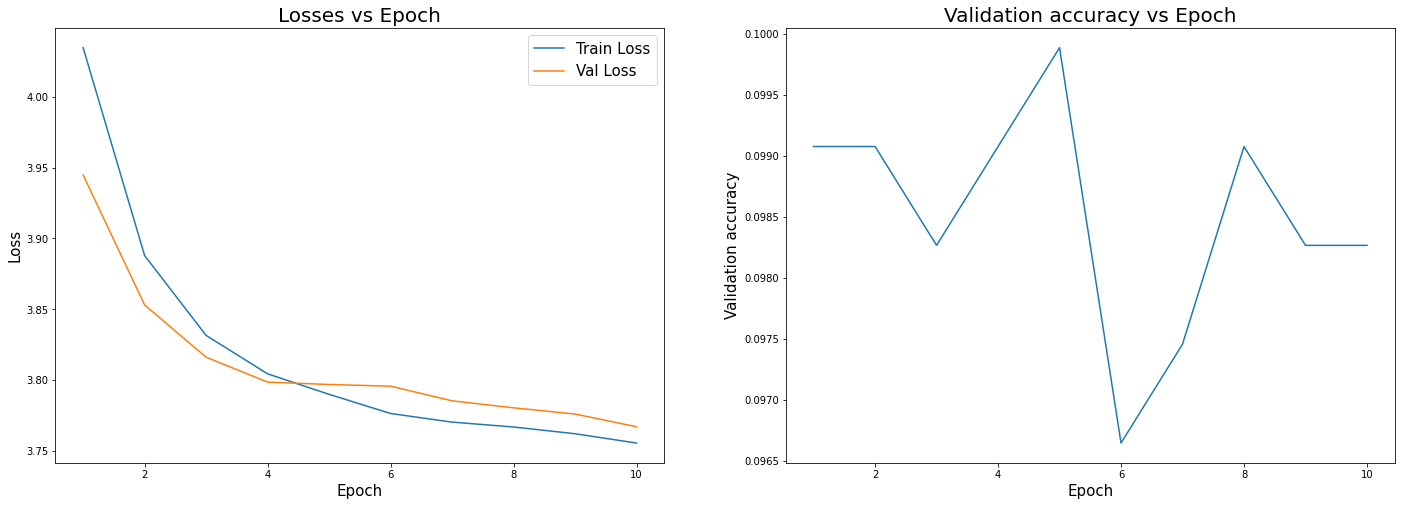

In [ ]:
plot_graphs(history)

### SGD optimizer

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.SGD
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 4.000645637512207, Validation loss: 3.8972930908203125, Validation accuracy: 0.09907408058643341



Epoch: 2, Train loss: 3.844634771347046, Validation loss: 3.826045036315918, Validation accuracy: 0.09907408058643341



Epoch: 3, Train loss: 3.7980148792266846, Validation loss: 3.8085105419158936, Validation accuracy: 0.09664352238178253



Epoch: 4, Train loss: 3.7855117321014404, Validation loss: 3.79439115524292, Validation accuracy: 0.1006944477558136



Epoch: 5, Train loss: 3.775753974914551, Validation loss: 3.7865352630615234, Validation accuracy: 0.09988425672054291



Epoch: 6, Train loss: 3.7692596912384033, Validation loss: 3.7787041664123535, Validation accuracy: 0.09907408058643341



Epoch: 7, Train loss: 3.7660157680511475, Validation loss: 3.7766549587249756, Validation accuracy: 0.10324074327945709



Epoch: 8, Train loss: 3.7581324577331543, Validation loss: 3.773270845413208, Validation accuracy: 0.09907408058643341



Epoch: 9, Train loss: 3.7484548091888428, Validation loss: 3.7561895847320557, Validation accuracy: 0.10462962836027145



Epoch: 10, Train loss: 3.742454767227173, Validation loss: 3.756591320037842, Validation accuracy: 0.10138888657093048



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 4.000645637512207	Val loss:  3.8972930908203125	Val acc: 0.09907408058643341
Epoch: 2	Train loss: 3.844634771347046	Val loss:  3.826045036315918	Val acc: 0.09907408058643341
Epoch: 3	Train loss: 3.7980148792266846	Val loss:  3.8085105419158936	Val acc: 0.09664352238178253
Epoch: 4	Train loss: 3.7855117321014404	Val loss:  3.79439115524292	Val acc: 0.1006944477558136
Epoch: 5	Train loss: 3.775753974914551	Val loss:  3.7865352630615234	Val acc: 0.09988425672054291
Epoch: 6	Train loss: 3.7692596912384033	Val loss:  3.7787041664123535	Val acc: 0.09907408058643341
Epoch: 7	Train loss: 3.7660157680511475	Val loss:  3.7766549587249756	Val acc: 0.10324074327945709
Epoch: 8	Train loss: 3.7581324577331543	Val loss:  3.773270845413208	Val acc: 0.09907408058643341
Epoch: 9	Train loss: 3.7484548091888428	Val loss:  3.7561895847320557	Val acc: 0.10462962836027145
Epoch: 10	Train loss: 3.742454767227173	Val loss:  3.756591320037842	Val acc: 0.10138888657093048


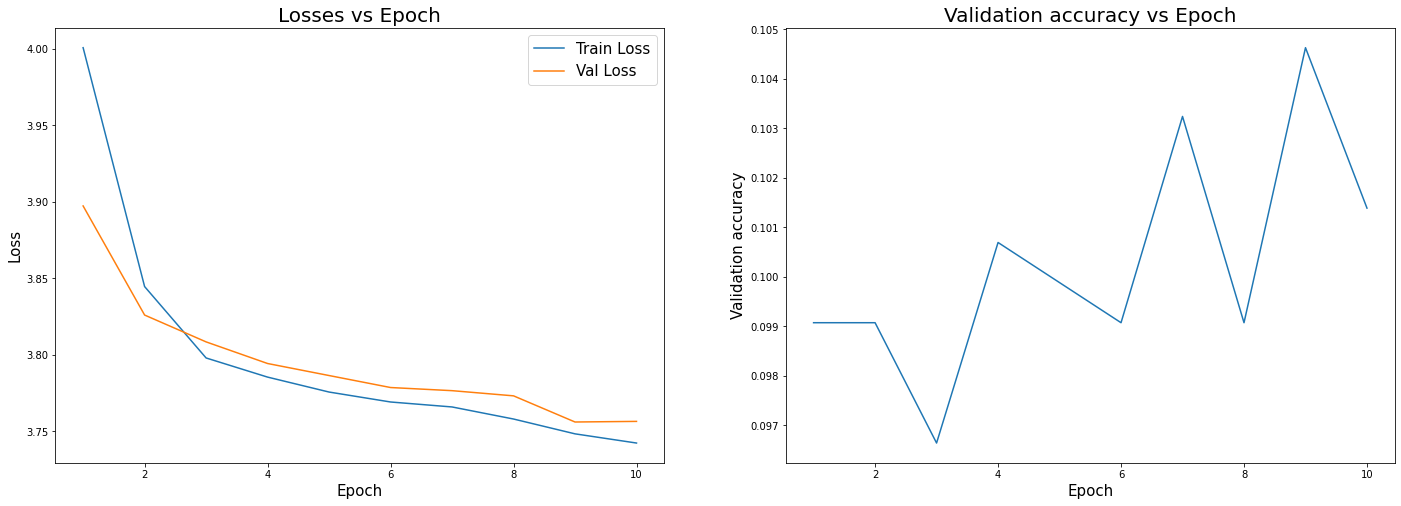

In [ ]:
plot_graphs(history)

### ASGD optimizer

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.ASGD
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 4.026073455810547, Validation loss: 3.9422898292541504, Validation accuracy: 0.09907408058643341



Epoch: 2, Train loss: 3.8657073974609375, Validation loss: 3.838827133178711, Validation accuracy: 0.09745370596647263



Epoch: 3, Train loss: 3.8071515560150146, Validation loss: 3.814948558807373, Validation accuracy: 0.09826388210058212



Epoch: 4, Train loss: 3.788914203643799, Validation loss: 3.8053979873657227, Validation accuracy: 0.09745370596647263



Epoch: 5, Train loss: 3.7808918952941895, Validation loss: 3.794296979904175, Validation accuracy: 0.09745370596647263



Epoch: 6, Train loss: 3.772162675857544, Validation loss: 3.793710231781006, Validation accuracy: 0.1006944477558136



Epoch: 7, Train loss: 3.7659127712249756, Validation loss: 3.781942129135132, Validation accuracy: 0.09907408058643341



Epoch: 8, Train loss: 3.761474609375, Validation loss: 3.7845582962036133, Validation accuracy: 0.09664352238178253



Epoch: 9, Train loss: 3.7582972049713135, Validation loss: 3.7807915210723877, Validation accuracy: 0.1006944477558136



Epoch: 10, Train loss: 3.756249189376831, Validation loss: 3.7725725173950195, Validation accuracy: 0.09826388210058212



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 4.026073455810547	Val loss:  3.9422898292541504	Val acc: 0.09907408058643341
Epoch: 2	Train loss: 3.8657073974609375	Val loss:  3.838827133178711	Val acc: 0.09745370596647263
Epoch: 3	Train loss: 3.8071515560150146	Val loss:  3.814948558807373	Val acc: 0.09826388210058212
Epoch: 4	Train loss: 3.788914203643799	Val loss:  3.8053979873657227	Val acc: 0.09745370596647263
Epoch: 5	Train loss: 3.7808918952941895	Val loss:  3.794296979904175	Val acc: 0.09745370596647263
Epoch: 6	Train loss: 3.772162675857544	Val loss:  3.793710231781006	Val acc: 0.1006944477558136
Epoch: 7	Train loss: 3.7659127712249756	Val loss:  3.781942129135132	Val acc: 0.09907408058643341
Epoch: 8	Train loss: 3.761474609375	Val loss:  3.7845582962036133	Val acc: 0.09664352238178253
Epoch: 9	Train loss: 3.7582972049713135	Val loss:  3.7807915210723877	Val acc: 0.1006944477558136
Epoch: 10	Train loss: 3.756249189376831	Val loss:  3.7725725173950195	Val acc: 0.09826388210058212


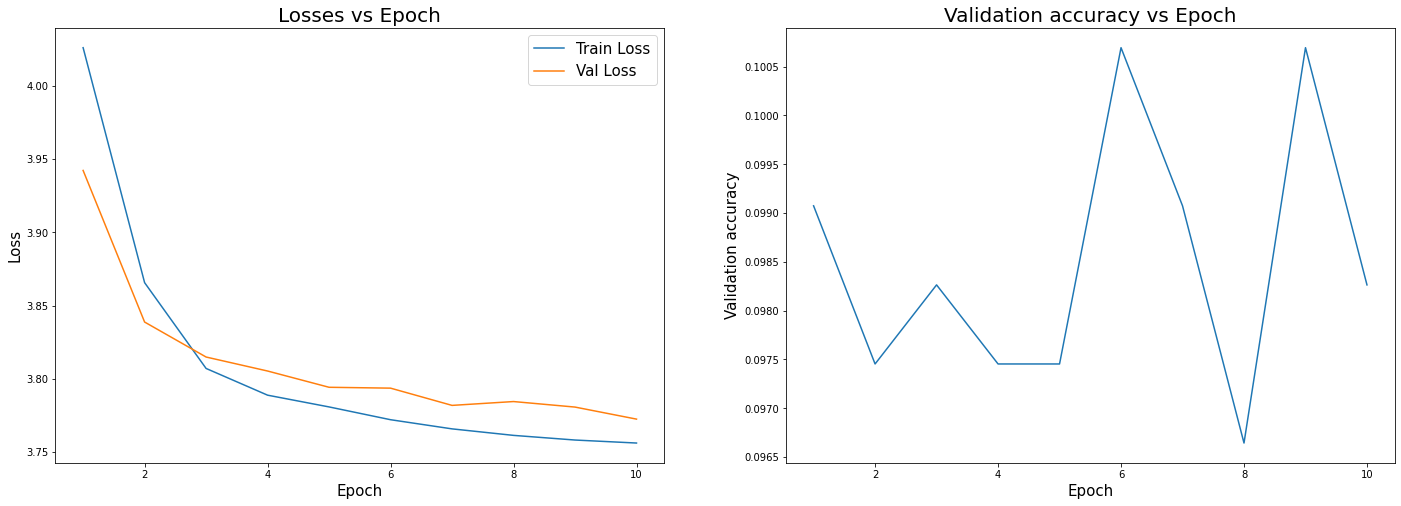

In [ ]:
plot_graphs(history)

### Rprop optimizer

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Rprop
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 6.121323108673096, Validation loss: 14.27906322479248, Validation accuracy: 0.15324074029922485



Epoch: 2, Train loss: 24.818941116333008, Validation loss: 35.20048141479492, Validation accuracy: 0.151157408952713



Epoch: 3, Train loss: 31.895442962646484, Validation loss: 39.62272644042969, Validation accuracy: 0.14398148655891418



Epoch: 4, Train loss: 32.19585418701172, Validation loss: 37.528717041015625, Validation accuracy: 0.14826388657093048



Epoch: 5, Train loss: 36.64980697631836, Validation loss: 57.77468490600586, Validation accuracy: 0.16122683882713318



Epoch: 6, Train loss: 42.362579345703125, Validation loss: 51.378746032714844, Validation accuracy: 0.1546296328306198



Epoch: 7, Train loss: 43.11530303955078, Validation loss: 51.515357971191406, Validation accuracy: 0.1553240716457367



Epoch: 8, Train loss: 44.24449157714844, Validation loss: 45.49114990234375, Validation accuracy: 0.1606481522321701



Epoch: 9, Train loss: 42.25450897216797, Validation loss: 54.504520416259766, Validation accuracy: 0.15324074029922485



Epoch: 10, Train loss: 46.080928802490234, Validation loss: 68.07528686523438, Validation accuracy: 0.14722222089767456



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 6.121323108673096	Val loss:  14.27906322479248	Val acc: 0.15324074029922485
Epoch: 2	Train loss: 24.818941116333008	Val loss:  35.20048141479492	Val acc: 0.151157408952713
Epoch: 3	Train loss: 31.895442962646484	Val loss:  39.62272644042969	Val acc: 0.14398148655891418
Epoch: 4	Train loss: 32.19585418701172	Val loss:  37.528717041015625	Val acc: 0.14826388657093048
Epoch: 5	Train loss: 36.64980697631836	Val loss:  57.77468490600586	Val acc: 0.16122683882713318
Epoch: 6	Train loss: 42.362579345703125	Val loss:  51.378746032714844	Val acc: 0.1546296328306198
Epoch: 7	Train loss: 43.11530303955078	Val loss:  51.515357971191406	Val acc: 0.1553240716457367
Epoch: 8	Train loss: 44.24449157714844	Val loss:  45.49114990234375	Val acc: 0.1606481522321701
Epoch: 9	Train loss: 42.25450897216797	Val loss:  54.504520416259766	Val acc: 0.15324074029922485
Epoch: 10	Train loss: 46.080928802490234	Val loss:  68.07528686523438	Val acc: 0.14722222089767456


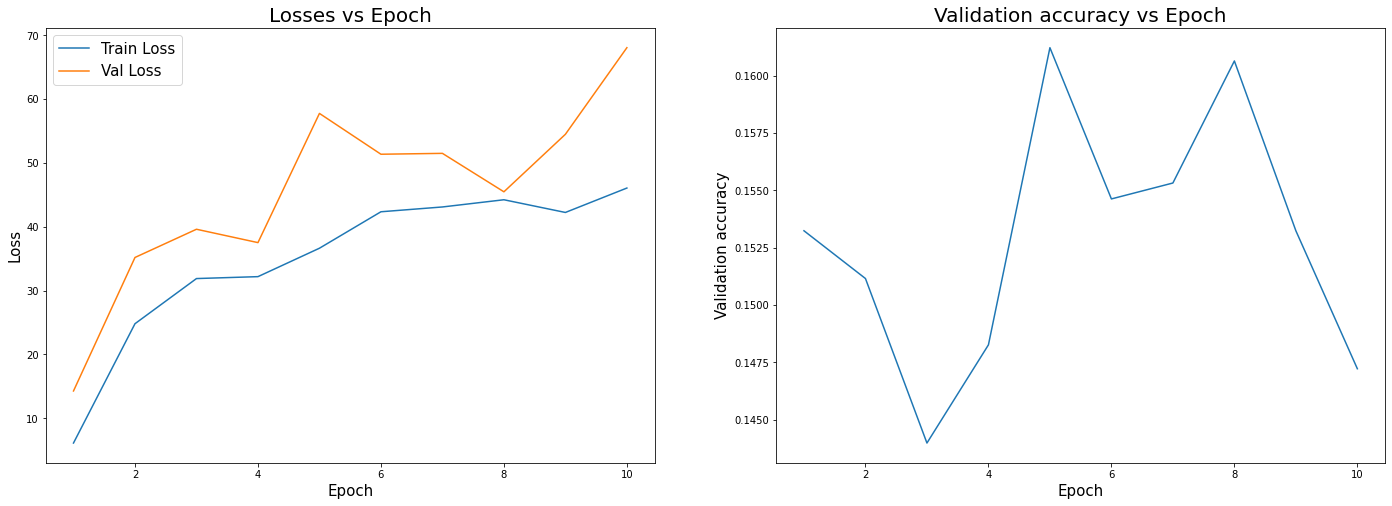

In [ ]:
plot_graphs(history)

### RMSprop optimizer

In [ ]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [ ]:
num_epochs = 10
opt_func = torch.optim.RMSprop
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 7.28810977935791, Validation loss: 5.719809055328369, Validation accuracy: 0.11863425374031067



Epoch: 2, Train loss: 3.2629294395446777, Validation loss: 4.2671613693237305, Validation accuracy: 0.11180555075407028



Epoch: 3, Train loss: 2.9353654384613037, Validation loss: 3.4502570629119873, Validation accuracy: 0.19629628956317902



Epoch: 4, Train loss: 2.591564416885376, Validation loss: 3.63614821434021, Validation accuracy: 0.20555557310581207



Epoch: 5, Train loss: 2.1440086364746094, Validation loss: 3.9088399410247803, Validation accuracy: 0.16215276718139648



Epoch: 6, Train loss: 1.5886420011520386, Validation loss: 4.193541526794434, Validation accuracy: 0.20081017911434174



Epoch: 7, Train loss: 0.970085620880127, Validation loss: 5.969281196594238, Validation accuracy: 0.17592592537403107



Epoch: 8, Train loss: 0.5311220288276672, Validation loss: 5.593277454376221, Validation accuracy: 0.21666666865348816



Epoch: 9, Train loss: 0.2627912759780884, Validation loss: 5.111316204071045, Validation accuracy: 0.2517361044883728



Epoch: 10, Train loss: 0.12533795833587646, Validation loss: 5.980954647064209, Validation accuracy: 0.22210648655891418



In [ ]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 7.28810977935791	Val loss:  5.719809055328369	Val acc: 0.11863425374031067
Epoch: 2	Train loss: 3.2629294395446777	Val loss:  4.2671613693237305	Val acc: 0.11180555075407028
Epoch: 3	Train loss: 2.9353654384613037	Val loss:  3.4502570629119873	Val acc: 0.19629628956317902
Epoch: 4	Train loss: 2.591564416885376	Val loss:  3.63614821434021	Val acc: 0.20555557310581207
Epoch: 5	Train loss: 2.1440086364746094	Val loss:  3.9088399410247803	Val acc: 0.16215276718139648
Epoch: 6	Train loss: 1.5886420011520386	Val loss:  4.193541526794434	Val acc: 0.20081017911434174
Epoch: 7	Train loss: 0.970085620880127	Val loss:  5.969281196594238	Val acc: 0.17592592537403107
Epoch: 8	Train loss: 0.5311220288276672	Val loss:  5.593277454376221	Val acc: 0.21666666865348816
Epoch: 9	Train loss: 0.2627912759780884	Val loss:  5.111316204071045	Val acc: 0.2517361044883728
Epoch: 10	Train loss: 0.12533795833587646	Val loss:  5.980954647064209	Val acc: 0.22210648655891418


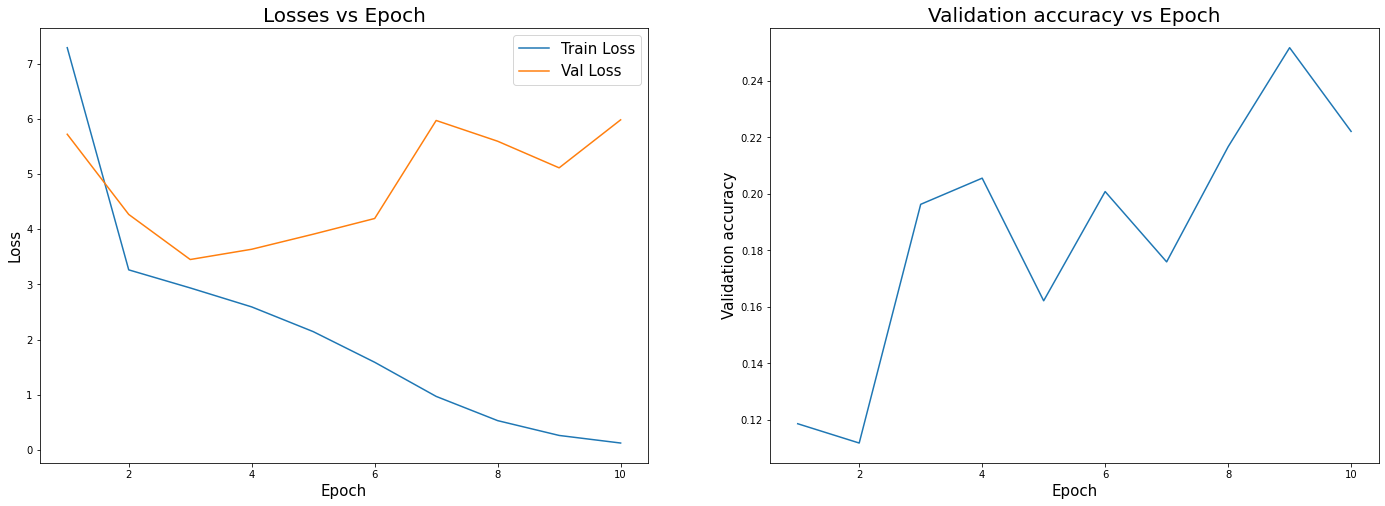

In [ ]:
plot_graphs(history)

# Basic augmentation

In [19]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, folder, class2index, transform=None):
        self.df = pd.read_csv(csv_path)[:2000]
        self.folder = folder
        self.transform = transform
        self.class2index = class2index
        self.num = len(self.df)
        
    def __len__(self):
        return 5*len(self.df)

    def __getitem__(self, index):
        fname = self.df['ImageId'][index%self.num]
        label = self.class2index[self.df["ClassName"][index%self.num]]
        image = Image.open(os.path.join(self.folder, fname))
        if index // self.num == 1:
            image = image.transpose(Image.ROTATE_90)
        elif index // self.num == 2:
            image = image.transpose(Image.ROTATE_90).transpose(Image.ROTATE_90)
        elif index // self.num == 3:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
        elif index // self.num == 4:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
 
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64))
])

dataset = AugmentedDataset(train_csv, train_path, class2index, transform)

In [21]:
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [22]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True)

In [23]:
train_dl = DeviceLoader(train_dl, device)
val_dl = DeviceLoader(val_dl, device)

In [24]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # 256 x 16 x 16
            nn.Flatten(),
            nn.Linear(256*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, 62)
        )

    def forward(self, x):
        return self.CNN(x)

In [25]:
model = ClassificationModel()
model
to_device(model, device)

ClassificationModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)

In [26]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [27]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 3.553797483444214, Validation loss: 3.225527763366699, Validation accuracy: 0.185546875



Epoch: 2, Train loss: 2.963552474975586, Validation loss: 2.9254727363586426, Validation accuracy: 0.23847655951976776



Epoch: 3, Train loss: 2.575881004333496, Validation loss: 2.766162395477295, Validation accuracy: 0.2535156309604645



Epoch: 4, Train loss: 2.1436853408813477, Validation loss: 2.5844342708587646, Validation accuracy: 0.3082031309604645



Epoch: 5, Train loss: 1.6299006938934326, Validation loss: 2.4509477615356445, Validation accuracy: 0.3375000059604645



Epoch: 6, Train loss: 1.0527278184890747, Validation loss: 2.214366912841797, Validation accuracy: 0.39238280057907104



Epoch: 7, Train loss: 0.5866565108299255, Validation loss: 2.4542980194091797, Validation accuracy: 0.38789063692092896



Epoch: 8, Train loss: 0.3040788769721985, Validation loss: 2.532304286956787, Validation accuracy: 0.40546876192092896



Epoch: 9, Train loss: 0.14754484593868256, Validation loss: 2.635645866394043, Validation accuracy: 0.4087890684604645



Epoch: 10, Train loss: 0.08977629989385605, Validation loss: 2.7500534057617188, Validation accuracy: 0.4488281309604645



In [28]:
for i in range(len(history['train_loss'])):
    print('Epoch: ' + str(i+1) + '\t' + 'Train loss: ' + str(history['train_loss'][i]) + '\t' + 'Val loss: ', str(history['val_loss'][i]) + '\t' + 'Val acc: ' + str(history['val_acc'][i]))

Epoch: 1	Train loss: 3.553797483444214	Val loss:  3.225527763366699	Val acc: 0.185546875
Epoch: 2	Train loss: 2.963552474975586	Val loss:  2.9254727363586426	Val acc: 0.23847655951976776
Epoch: 3	Train loss: 2.575881004333496	Val loss:  2.766162395477295	Val acc: 0.2535156309604645
Epoch: 4	Train loss: 2.1436853408813477	Val loss:  2.5844342708587646	Val acc: 0.3082031309604645
Epoch: 5	Train loss: 1.6299006938934326	Val loss:  2.4509477615356445	Val acc: 0.3375000059604645
Epoch: 6	Train loss: 1.0527278184890747	Val loss:  2.214366912841797	Val acc: 0.39238280057907104
Epoch: 7	Train loss: 0.5866565108299255	Val loss:  2.4542980194091797	Val acc: 0.38789063692092896
Epoch: 8	Train loss: 0.3040788769721985	Val loss:  2.532304286956787	Val acc: 0.40546876192092896
Epoch: 9	Train loss: 0.14754484593868256	Val loss:  2.635645866394043	Val acc: 0.4087890684604645
Epoch: 10	Train loss: 0.08977629989385605	Val loss:  2.7500534057617188	Val acc: 0.4488281309604645


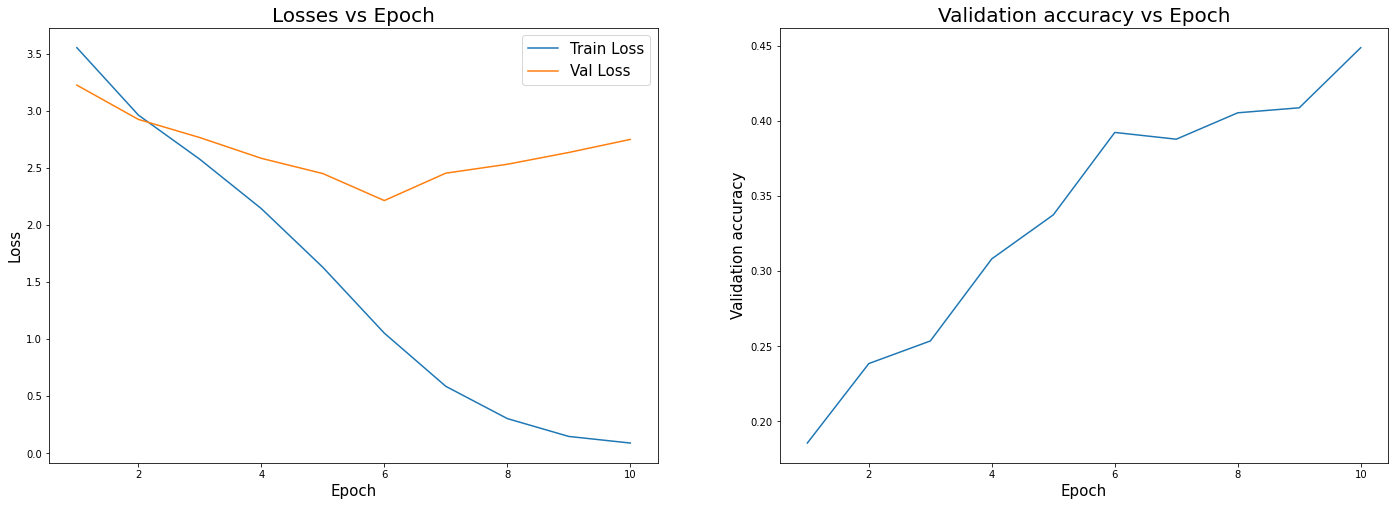

In [29]:
plot_graphs(history)

# Predicting Images

In [ ]:
def predict(img, model):
    x = to_device(img.unsqueeze(0), device)
    y = model.forward(x)
    _, preds = torch.max(y, dim=1)

    return index2class[preds[0].item()]

In [ ]:
with open(test_csv, 'r') as f:
    data = f.read()
    rows = data.split('\n')[1:-1]

In [ ]:
ts_out = []
for i in rows:
    im = Image.open(os.path.join(test_path, i))
    im = transform(im)
    lab = predict(im, model)
    ts_out.append([i, lab])

test_outputs = pd.DataFrame(ts_out, columns=['ImageId', 'ClassName'])
test_outputs.to_csv('submit.csv')